Imports

In [183]:
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import collections
%matplotlib inline

import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from time import time
from scipy import ndimage
from sklearn import manifold

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import operator

In [26]:
with open('LargeBinaryChampionsDataset.pkl', 'rb') as inp:
    original_dataset_digits = pk.load(inp) #pd.read_csv('dataset_champion_indices.csv')

making the dataset in 0-1 format

In [27]:
original_dataset = []
for sample in original_dataset_digits.as_matrix()[:,:-1]:
    if np.any(sample > 131) or np.any(sample < 0):
        continue
    w = np.zeros(132)
    for s in sample[0:5]:
        w[s] = 1
    l = np.zeros(132)
    for s in sample[5:10]:
        l[s] = 1
    original_dataset.append(np.hstack((w,l)))

In [28]:
dataset = pd.DataFrame(original_dataset)
dataset = dataset.sample(n=10000, replace=False)

In [205]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,255,256,257,258,259,260,261,262,263,label
8104,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26931,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Champion counts chosen by winners and losers

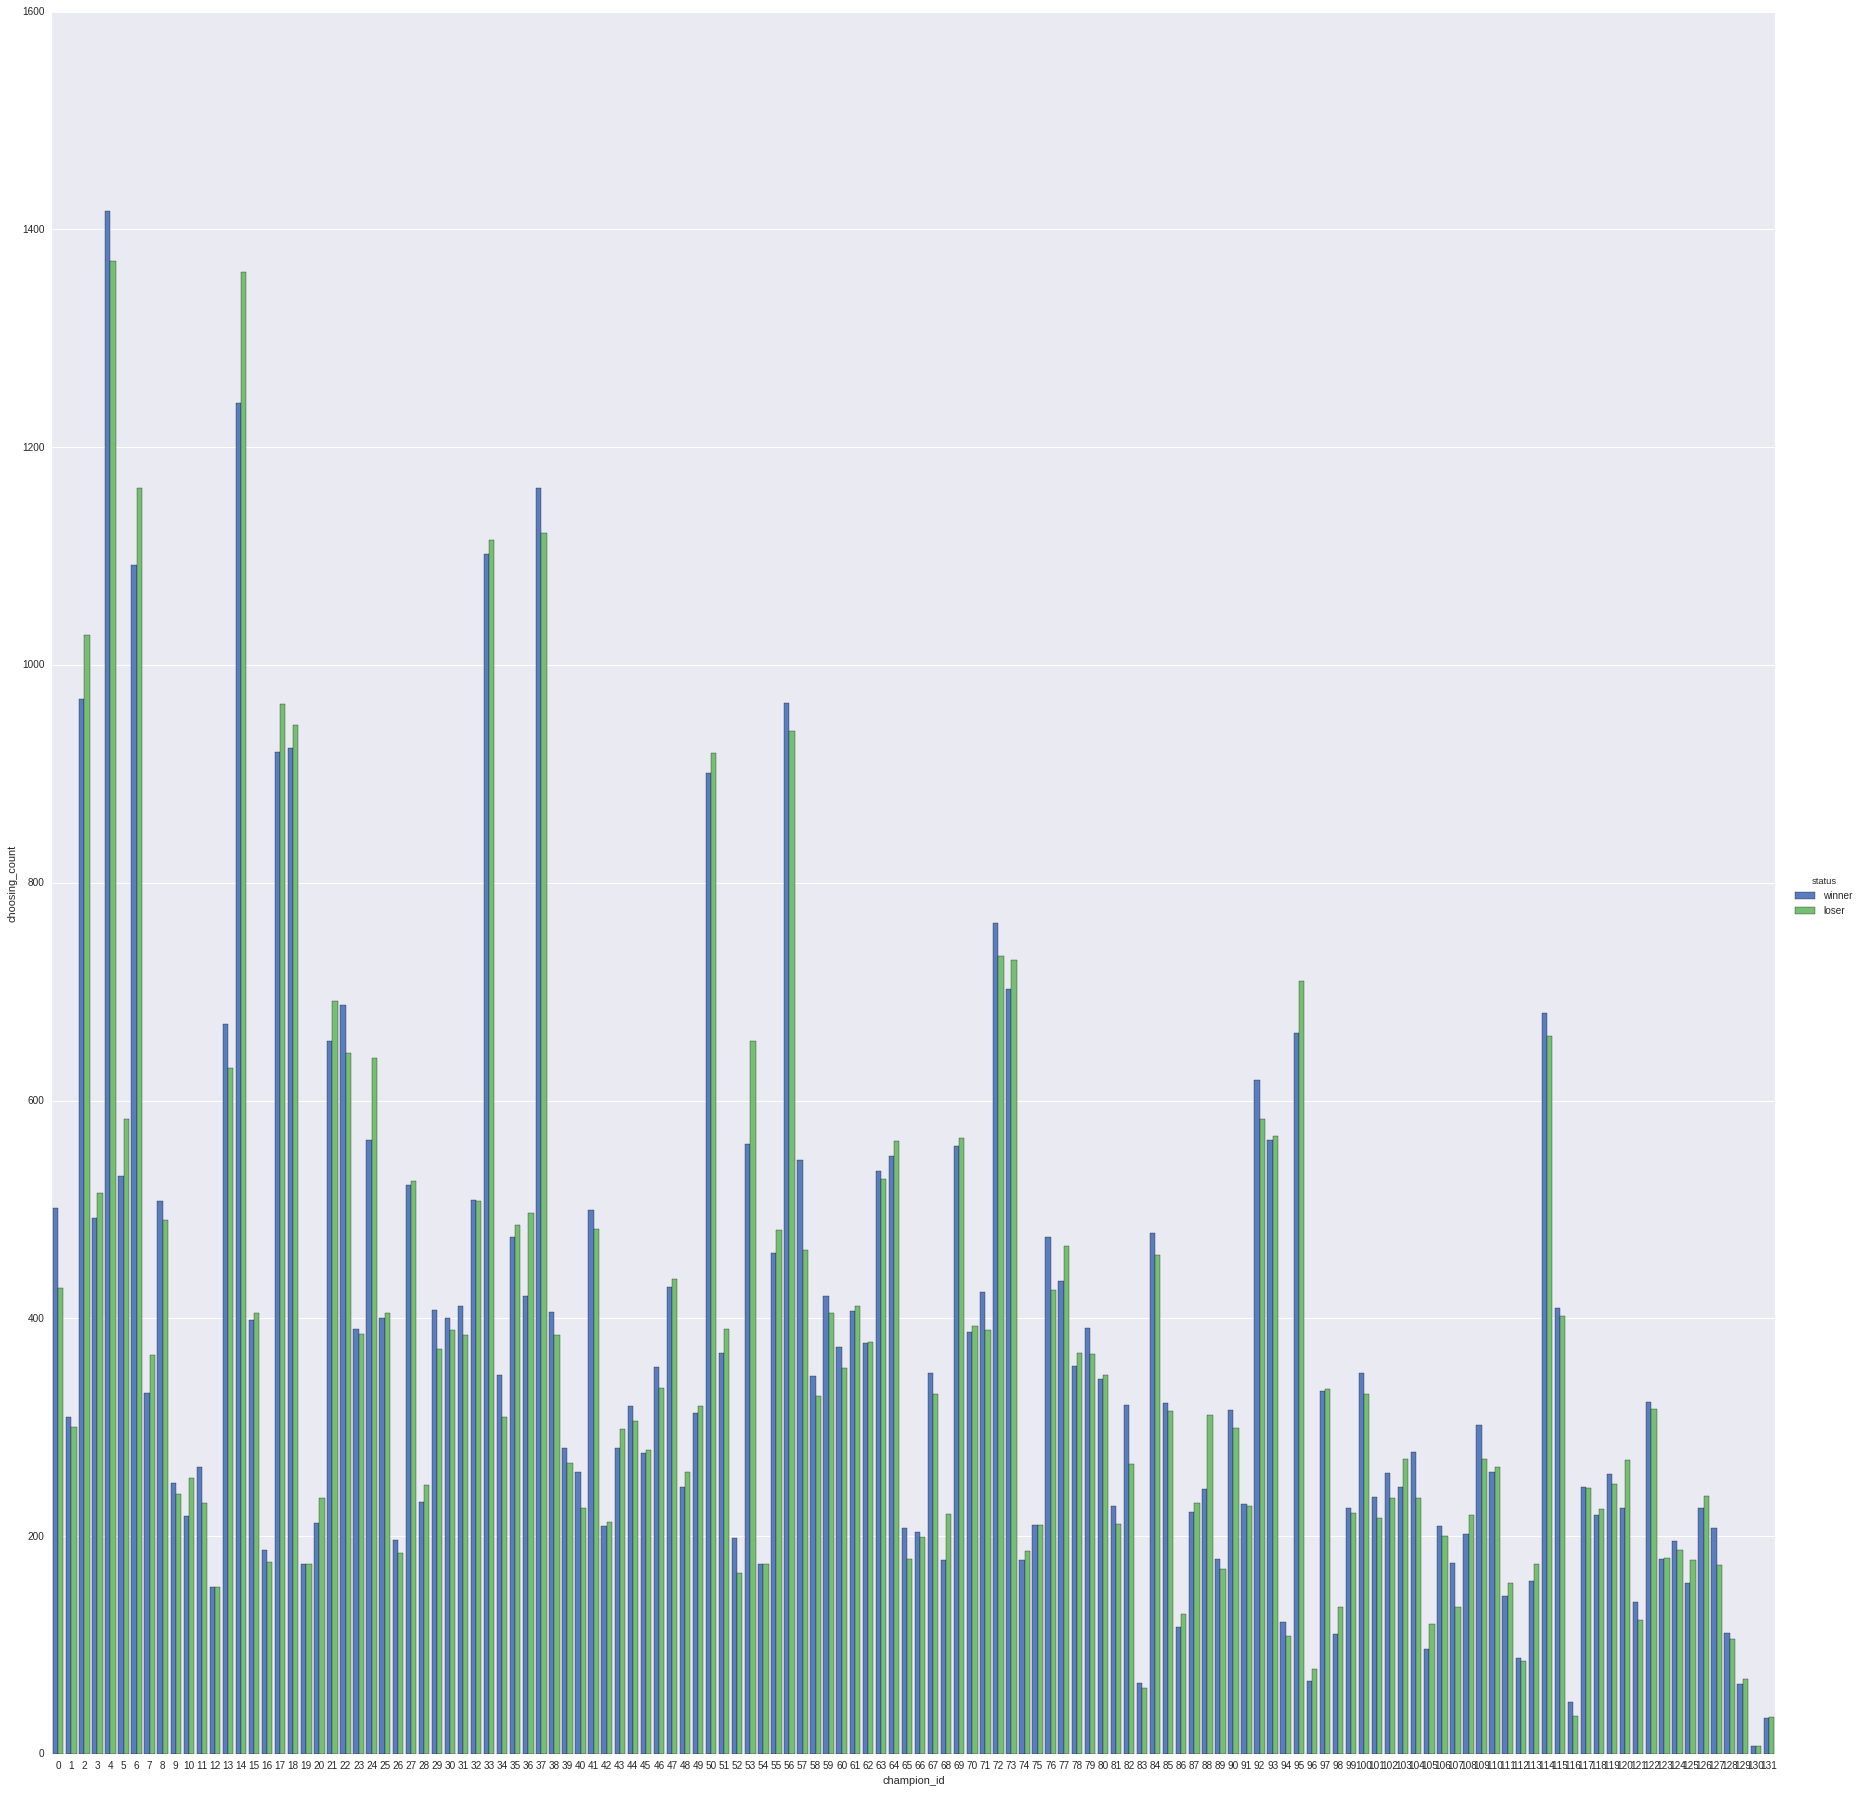

In [202]:
# all_winners = dataset.ix[:,:132]
# all_losers = dataset.ix[:,132:]

# all_counts = []
# for i in range(132):
#     all_counts.append([i, len(np.where(all_winners.ix[:,i]==1)[0]), len(np.where(all_losers.ix[:,i]==1)[0])])
# pd.DataFrame(all_counts, columns=['champion_id', 'winner', 'loser'])


all_winners = dataset.ix[:,:132].as_matrix()
all_losers = dataset.ix[:,132:].as_matrix()
all_counts = []
for i in range(132):
    all_counts.append([i, len(np.where(all_winners[:,i]==1)[0]), 'winner'])
for i in range(132):
    all_counts.append([i, len(np.where(all_losers[:,i]==1)[0]), 'loser'])
dt = pd.DataFrame(all_counts, columns=['champion_id', 'choosing_count', 'status'])

g = sns.factorplot(x="champion_id", y="choosing_count", hue="status", data=dt,
                   size=25, kind="bar", palette="muted")

Adding label and swapping 50% of winners and losers

In [30]:
dataset['label'] = np.zeros([len(dataset),1])
dt = dataset.as_matrix()
idx = np.random.choice(len(dt), int(len(dt)/2), replace=False)
tf = math.floor(dt.shape[1]/2)
tmp = dt[idx,tf:2*tf]
dt[idx,tf:2*tf] = dt[idx,:tf]
dt[idx,:tf] = tmp
dt[idx,-1] = 1

In [31]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,255,256,257,258,259,260,261,262,263,label
8104,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26931,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Now dataset is ready for classification

In [ ]:
# %load do_classification.py
#Omid55
def do_classification(dataset, verbose=True):
    
    if type(dataset) is pd.core.frame.DataFrame:
        dataset = dataset.as_matrix()

    #clf = MLPClassifier(algorithm='l-bfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    models = [(LogisticRegression(), 'Logistic Regression'),
        (GaussianNB(), 'Naive Bayes'),
        (svm.LinearSVC(C=1.0, verbose=False), 'Linear SVM'),
        (svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False), 'SVM with RBF kernel'),
        (RandomForestClassifier(n_estimators=100), 'Random Forest'),
        (KNeighborsClassifier(n_neighbors=8), 'KNN'),
        (DecisionTreeClassifier(max_depth=5), 'Decision Tree'),
        (AdaBoostClassifier(), 'AdaBoost'),
        (LinearDiscriminantAnalysis(), 'Linear Discriminant Analysis'),
        (QuadraticDiscriminantAnalysis(), 'Quadratic Discriminant Analysis')]
    
    # applying the models
    n_folds = 10
    k_fold = cross_validation.KFold(n=len(dataset), n_folds=n_folds, shuffle=False, random_state=None)
    accuracy = {}
    for train_index, test_index in k_fold:
        X_train = dataset[train_index,:-1]
        y_train = dataset[train_index,-1]
        X_test = dataset[test_index,:-1]
        y_test = dataset[test_index,-1]

        for clf, name in models:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy_percent = 100 * sk.metrics.accuracy_score(y_test, y_pred) / n_folds
            if name not in accuracy:
                accuracy[name] = accuracy_percent
            else:
                accuracy[name] += accuracy_percent
    if verbose:
        for key, value in accuracy.items():
            print(key, ':', round(value,2))
    return accuracy


# Plotting data

TNSE

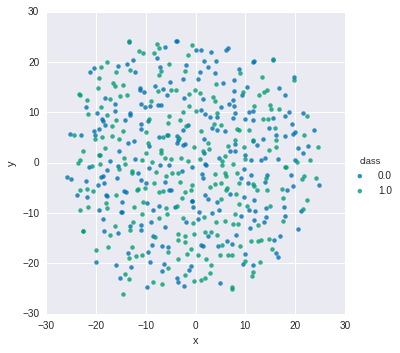

In [33]:
#sns.set(rc={"figure.figsize": (12, 12)})
def plot_TSNE(data, labels):
    tsne_model = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    points = tsne_model.fit_transform(data)
    df = pd.DataFrame(data=np.column_stack([points,labels]), columns=["x","y","class"])
    sns.lmplot("x", "y", data=df, hue='class', fit_reg=False, palette=sns.color_palette('colorblind'))
    #sns.plt.plot(figsize=(20, 20))
    sns.plt.show()
    
dtt = dataset.sample(n=500, replace=False)
plot_TSNE(dtt.ix[:,:dtt.shape[1]-1], dtt['label'])

PCA

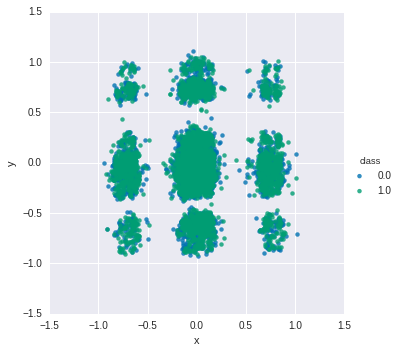

In [34]:
def plot_PCA(data, labels):
    pca = PCA(n_components=2)
    pca.fit(data)
    data = pca.transform(data)
    df = pd.DataFrame(data=np.column_stack([data,labels]), columns=["x","y","class"])
    sns.lmplot("x", "y", data=df, hue='class', fit_reg=False, palette=sns.color_palette('colorblind'))
    sns.plt.show()
    
plot_PCA(dataset.ix[:,:-1], dataset['label'])

Hierarchical clustering

In [ ]:
# since heirachical clustering needs to compute all samples 2 by 2 we have to resample the dataset
dtt = dataset.sample(n=4000, replace=False)
X = np.asmatrix(dtt.ix[:,:-1])
y = np.asanyarray(dtt['label'])
n_samples, n_features = X.shape

# 5 Clusters

Computing embedding
Done.
ward : 16.96s
average : 17.33s
complete : 17.03s


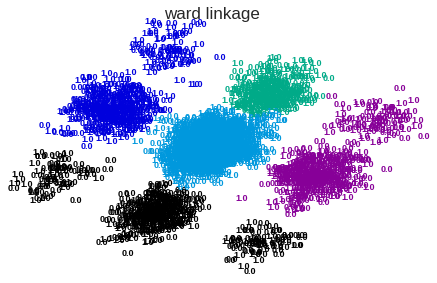

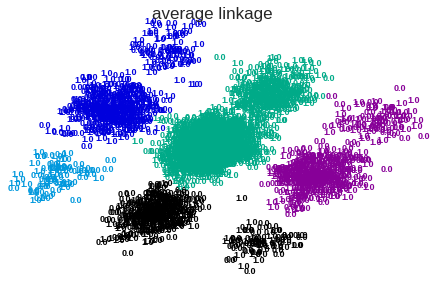

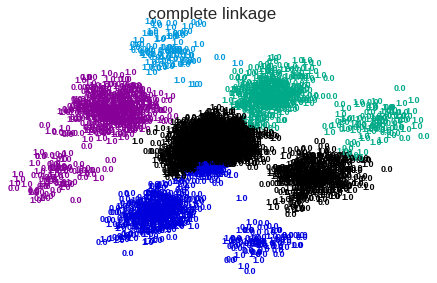

In [45]:
NUMBER_OF_CLUSTERS = 5

#----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

#----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=NUMBER_OF_CLUSTERS)
    t0 = time()
    clustering.fit(X_red)
    print("%s : %.2fs" % (linkage, time() - t0))
    plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)

plt.show()

In [46]:
import warnings
warnings.filterwarnings('ignore')

print('Classification on whole dataset:')
acc = do_classification(dtt)

Classification on whole dataset:
AdaBoost : 51.4
Linear Discriminant Analysis : 50.8
Random Forest : 50.53
SVM with RBF kernel : 49.42
Linear SVM : 50.78
Decision Tree : 50.15
KNN : 50.85
Naive Bayes : 50.05
Quadratic Discriminant Analysis : 50.25
Logistic Regression : 50.78


In [47]:
for linkage in ('ward', 'average', 'complete'):
    accuracies = collections.defaultdict(lambda: 0)
    print('Linkage is', linkage, '=>\n\n')
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=NUMBER_OF_CLUSTERS)
    clustering.fit(X_red)
    for cluster_index in range(NUMBER_OF_CLUSTERS):
        idx = np.where(clustering.labels_==cluster_index)[0]
        print('Length of this cluster is:', len(idx),'\n')
        if len(idx) > 20:
            accuracy = do_classification(np.column_stack((X[idx,:], y[idx])), verbose=True)
            print('\n----------------------------------------------\n')
#         for k, v in accuracy.items():
#             accuracies[k] += v / float(NUMBER_OF_CLUSTERS)
#     print('Average classification accuracy on clusters is:')
#     for key, value in accuracies.items():
#         print(key, ':', round(value,2))
    print('\n\n\n================================================')

Linkage is ward =>


Length of this cluster is: 503 

AdaBoost : 50.51
Linear Discriminant Analysis : 48.15
Random Forest : 51.9
SVM with RBF kernel : 56.86
Linear SVM : 48.93
Decision Tree : 56.26
KNN : 59.44
Naive Bayes : 47.31
Quadratic Discriminant Analysis : 55.47
Logistic Regression : 51.5

----------------------------------------------

Length of this cluster is: 490 

AdaBoost : 47.96
Linear Discriminant Analysis : 49.18
Random Forest : 51.02
SVM with RBF kernel : 52.86
Linear SVM : 50.0
Decision Tree : 49.8
KNN : 48.16
Naive Bayes : 47.96
Quadratic Discriminant Analysis : 53.06
Logistic Regression : 50.41

----------------------------------------------

Length of this cluster is: 478 

AdaBoost : 50.41
Linear Discriminant Analysis : 51.45
Random Forest : 51.04
SVM with RBF kernel : 52.11
Linear SVM : 48.95
Decision Tree : 49.77
KNN : 52.48
Naive Bayes : 46.21
Quadratic Discriminant Analysis : 48.71
Logistic Regression : 49.14

----------------------------------------------

Le

# 9 Clusters

Computing embedding
Done.
ward : 17.94s
average : 18.46s
complete : 18.17s


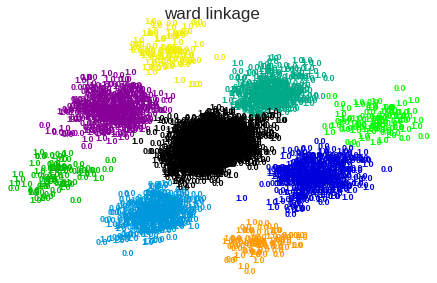

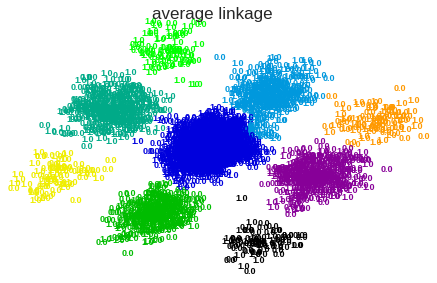

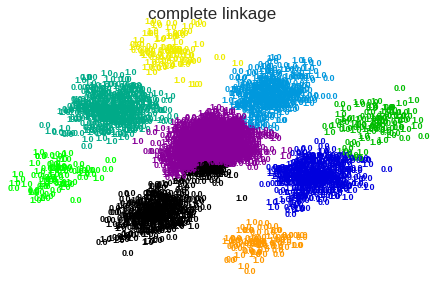

In [48]:
NUMBER_OF_CLUSTERS = 9

#----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

#----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=NUMBER_OF_CLUSTERS)
    t0 = time()
    clustering.fit(X_red)
    print("%s : %.2fs" % (linkage, time() - t0))
    plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)

plt.show()

In [184]:
just_print_the_best = True
for linkage in ('ward', 'average', 'complete'):
    accuracies = collections.defaultdict(lambda: 0)
    print('Linkage is', linkage, '=>\n\n')
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=NUMBER_OF_CLUSTERS)
    clustering.fit(X_red)
    for cluster_index in range(NUMBER_OF_CLUSTERS):
        idx = np.where(clustering.labels_==cluster_index)[0]
        print('Length of this cluster is:', len(idx),'\n')
        if len(idx) > 20:
            if just_print_the_best:
                accuracy = do_classification(np.column_stack((X[idx,:], y[idx])), verbose=False)
                print(max(accuracy.items(), key=operator.itemgetter(1)))
            else:
                accuracy = do_classification(np.column_stack((X[idx,:], y[idx])), verbose=True)
            print('\n----------------------------------------------\n')
    print('\n\n\n================================================')

Linkage is ward =>


Length of this cluster is: 2203 

('Naive Bayes', 50.299053887289176)

----------------------------------------------

Length of this cluster is: 400 

('SVM with RBF kernel', 52.5)

----------------------------------------------

Length of this cluster is: 403 

('Linear Discriminant Analysis', 52.341463414634148)

----------------------------------------------

Length of this cluster is: 356 

('KNN', 58.714285714285722)

----------------------------------------------

Length of this cluster is: 326 

('Decision Tree', 53.977272727272727)

----------------------------------------------

Length of this cluster is: 74 

('Linear Discriminant Analysis', 66.25)

----------------------------------------------

Length of this cluster is: 87 

('Linear Discriminant Analysis', 57.222222222222214)

----------------------------------------------

Length of this cluster is: 78 

('Linear SVM', 53.75)

----------------------------------------------

Length of this cluster is

In [192]:
just_print_the_best = False
for linkage in ('ward', 'average', 'complete'):
    accuracies = collections.defaultdict(lambda: 0)
    print('Linkage is', linkage, '=>\n\n')
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=NUMBER_OF_CLUSTERS)
    clustering.fit(X_red)
    for cluster_index in range(NUMBER_OF_CLUSTERS):
        idx = np.where(clustering.labels_==cluster_index)[0]
        print('Length of this cluster is:', len(idx),'\n')
        if len(idx) > 20:
            if just_print_the_best:
                accuracy = do_classification(np.column_stack((X[idx,:], y[idx])), verbose=False)
                print(max(accuracy.items(), key=operator.itemgetter(1)))
            else:
                accuracy = do_classification(np.column_stack((X[idx,:], y[idx])), verbose=True)
            print('\n----------------------------------------------\n')
    print('\n\n\n================================================')

Linkage is ward =>


Length of this cluster is: 2203 

AdaBoost : 49.75
Linear Discriminant Analysis : 49.03
Random Forest : 49.12
SVM with RBF kernel : 47.39
Linear SVM : 48.98
Decision Tree : 48.34
KNN : 49.52
Naive Bayes : 50.3
Quadratic Discriminant Analysis : 49.2
Logistic Regression : 49.53

----------------------------------------------

Length of this cluster is: 400 

AdaBoost : 49.75
Linear Discriminant Analysis : 47.75
Random Forest : 52.5
SVM with RBF kernel : 52.5
Linear SVM : 46.5
Decision Tree : 52.75
KNN : 51.0
Naive Bayes : 46.0
Quadratic Discriminant Analysis : 52.0
Logistic Regression : 47.75

----------------------------------------------

Length of this cluster is: 403 

AdaBoost : 46.67
Linear Discriminant Analysis : 52.34
Random Forest : 48.38
SVM with RBF kernel : 52.11
Linear SVM : 50.38
Decision Tree : 49.38
KNN : 48.58
Naive Bayes : 47.63
Quadratic Discriminant Analysis : 49.93
Logistic Regression : 48.88

----------------------------------------------

Lengt

In [172]:
def print_one_cluster_champions(clustering, cluster_label):
    idx = np.where(clustering.labels_==cluster_label)[0]
    print('Length of this cluster is:', len(idx))
    cluster8 = np.column_stack((X[idx,:], y[idx]))

    winners = np.vstack((cluster8[np.where(cluster8[:,-1] == 1)[0],:132], cluster8[np.where(cluster8[:,-1] == 0)[0],132:-1]))
    losers = np.vstack((cluster8[np.where(cluster8[:,-1] == 1)[0],132:-1], cluster8[np.where(cluster8[:,-1] == 0)[0],:132]))

    counts = []
    for i in range(132):
        counts.append([i, len(np.where(winners[:,i]==1)[0]), 'winner'])
    for i in range(132):
        counts.append([i, len(np.where(losers[:,i]==1)[0]), 'loser'])
    dt = pd.DataFrame(counts, columns=['champion_id', 'choosing_count', 'status'])
    g = sns.factorplot(x="champion_id", y="choosing_count", hue="status", data=dt,
                       size=25, kind="bar", palette="muted")
    g.fig.show()

In [190]:
clustering = AgglomerativeClustering(linkage='ward', n_clusters=9)
clustering.fit(X_red)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=9, n_components=None,
            pooling_func=<function mean at 0x7fc5bc100950>)

Length of this cluster is: 2203
Length of this cluster is: 400
Length of this cluster is: 403
Length of this cluster is: 356
Length of this cluster is: 326
Length of this cluster is: 74
Length of this cluster is: 87
Length of this cluster is: 78
Length of this cluster is: 73


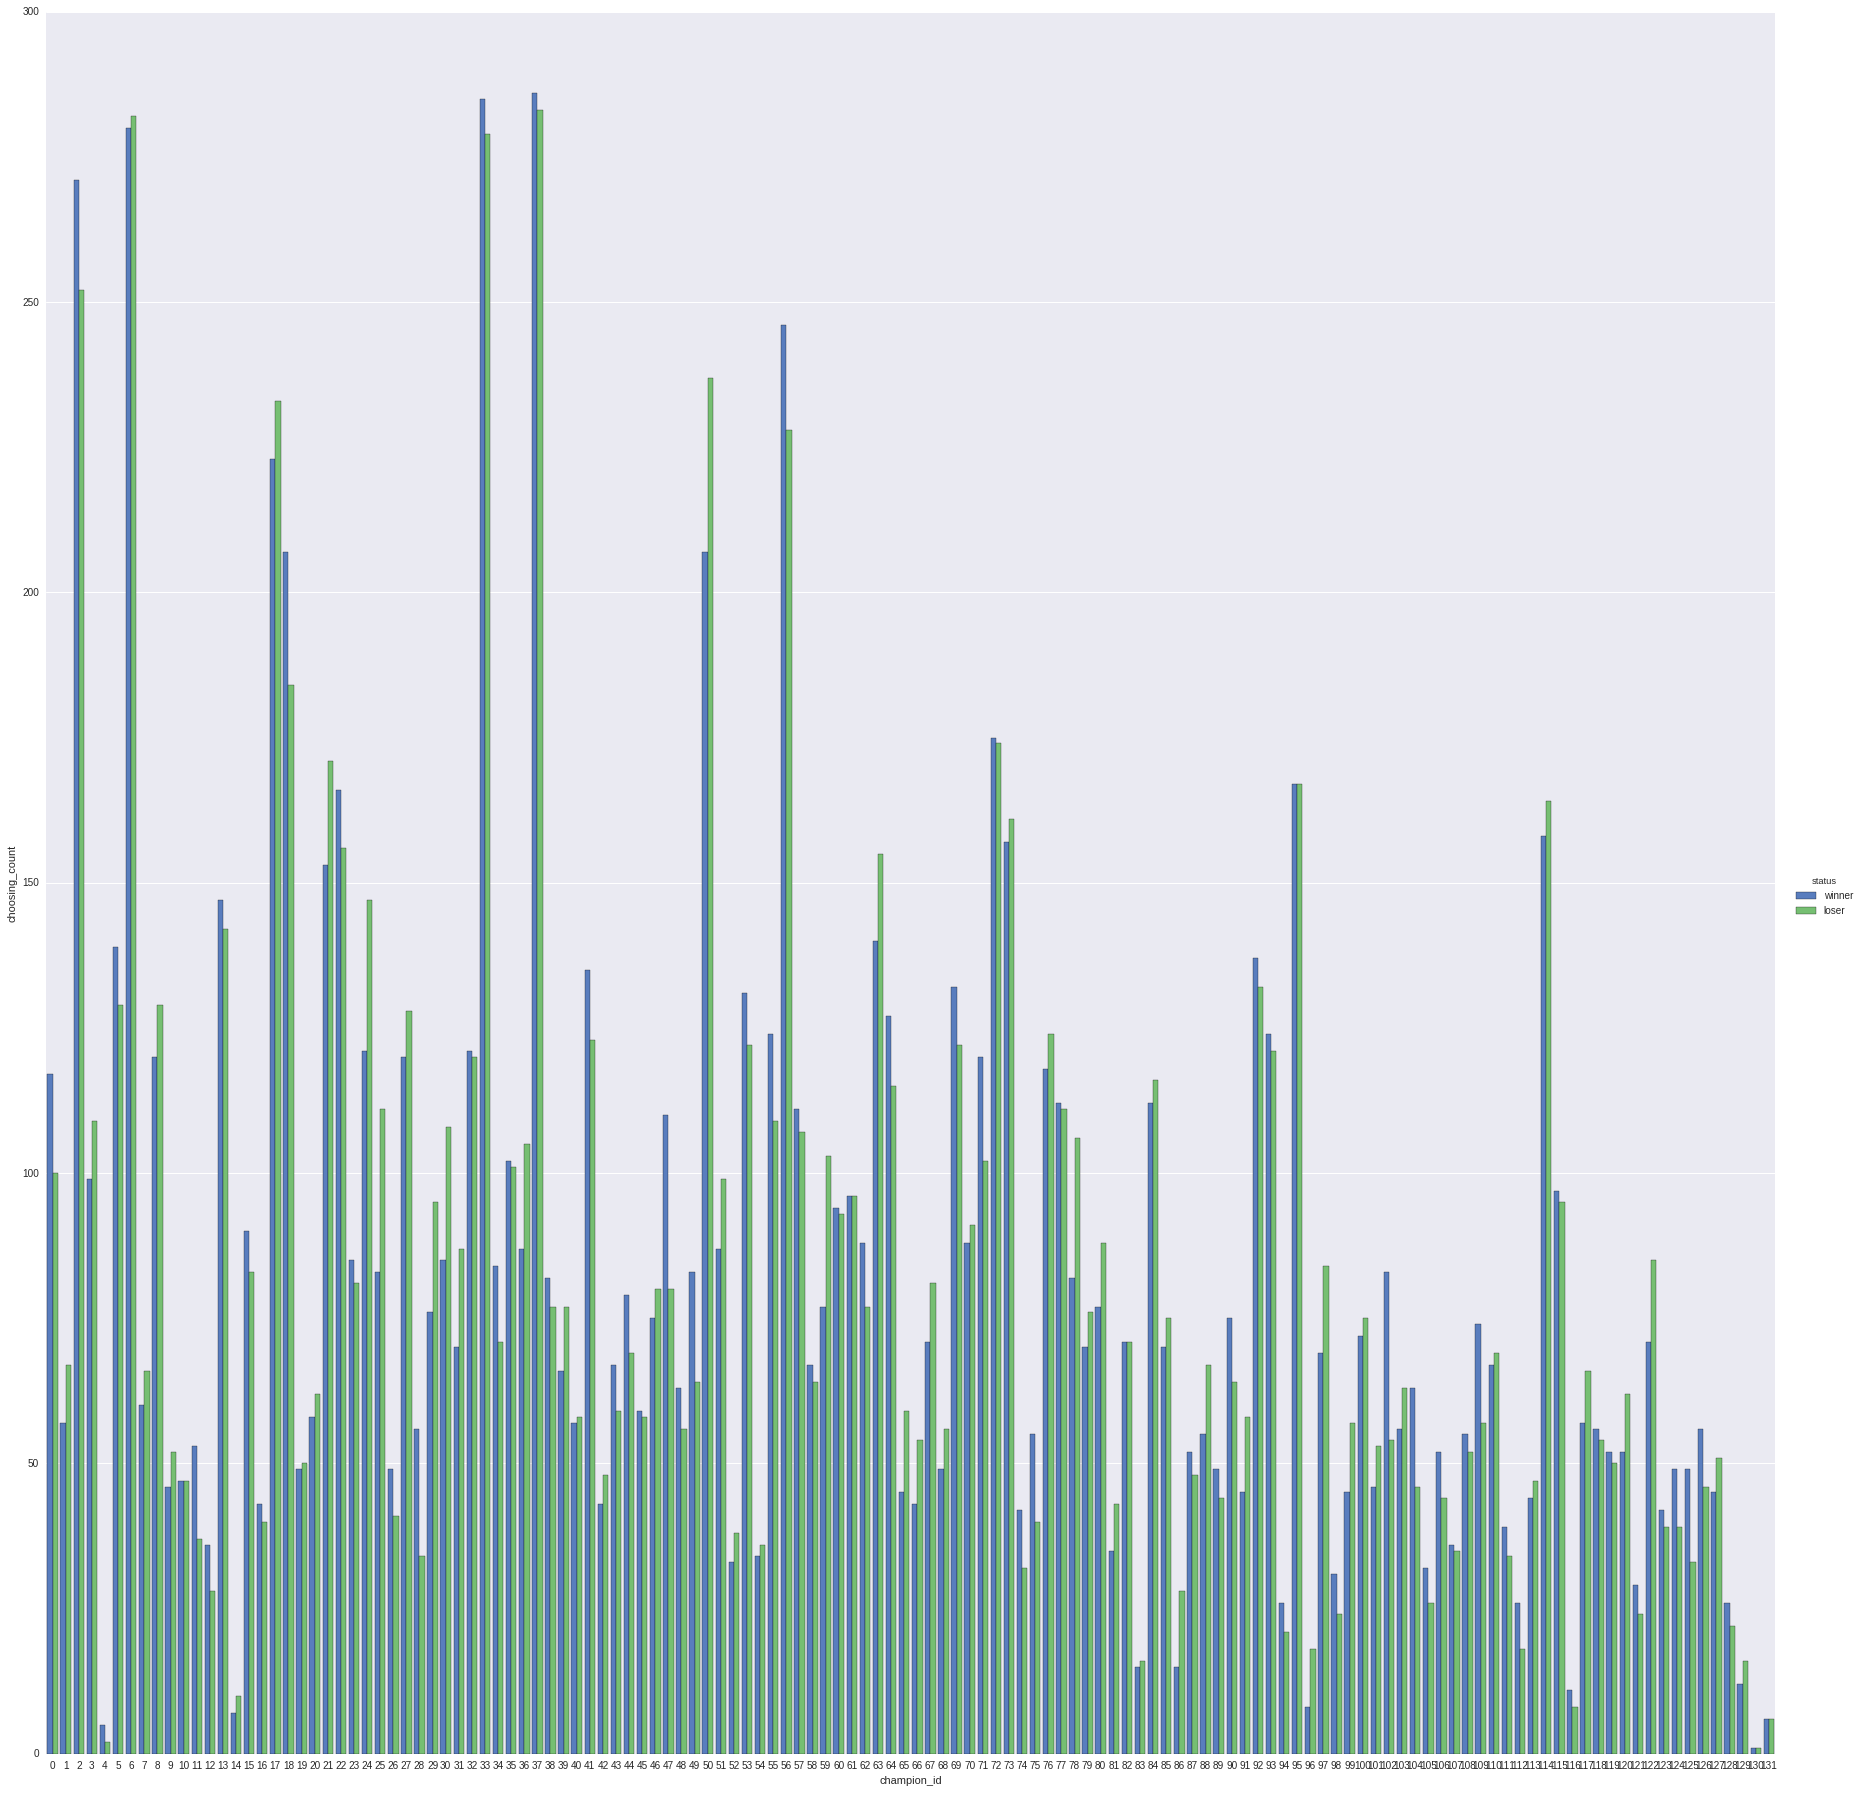

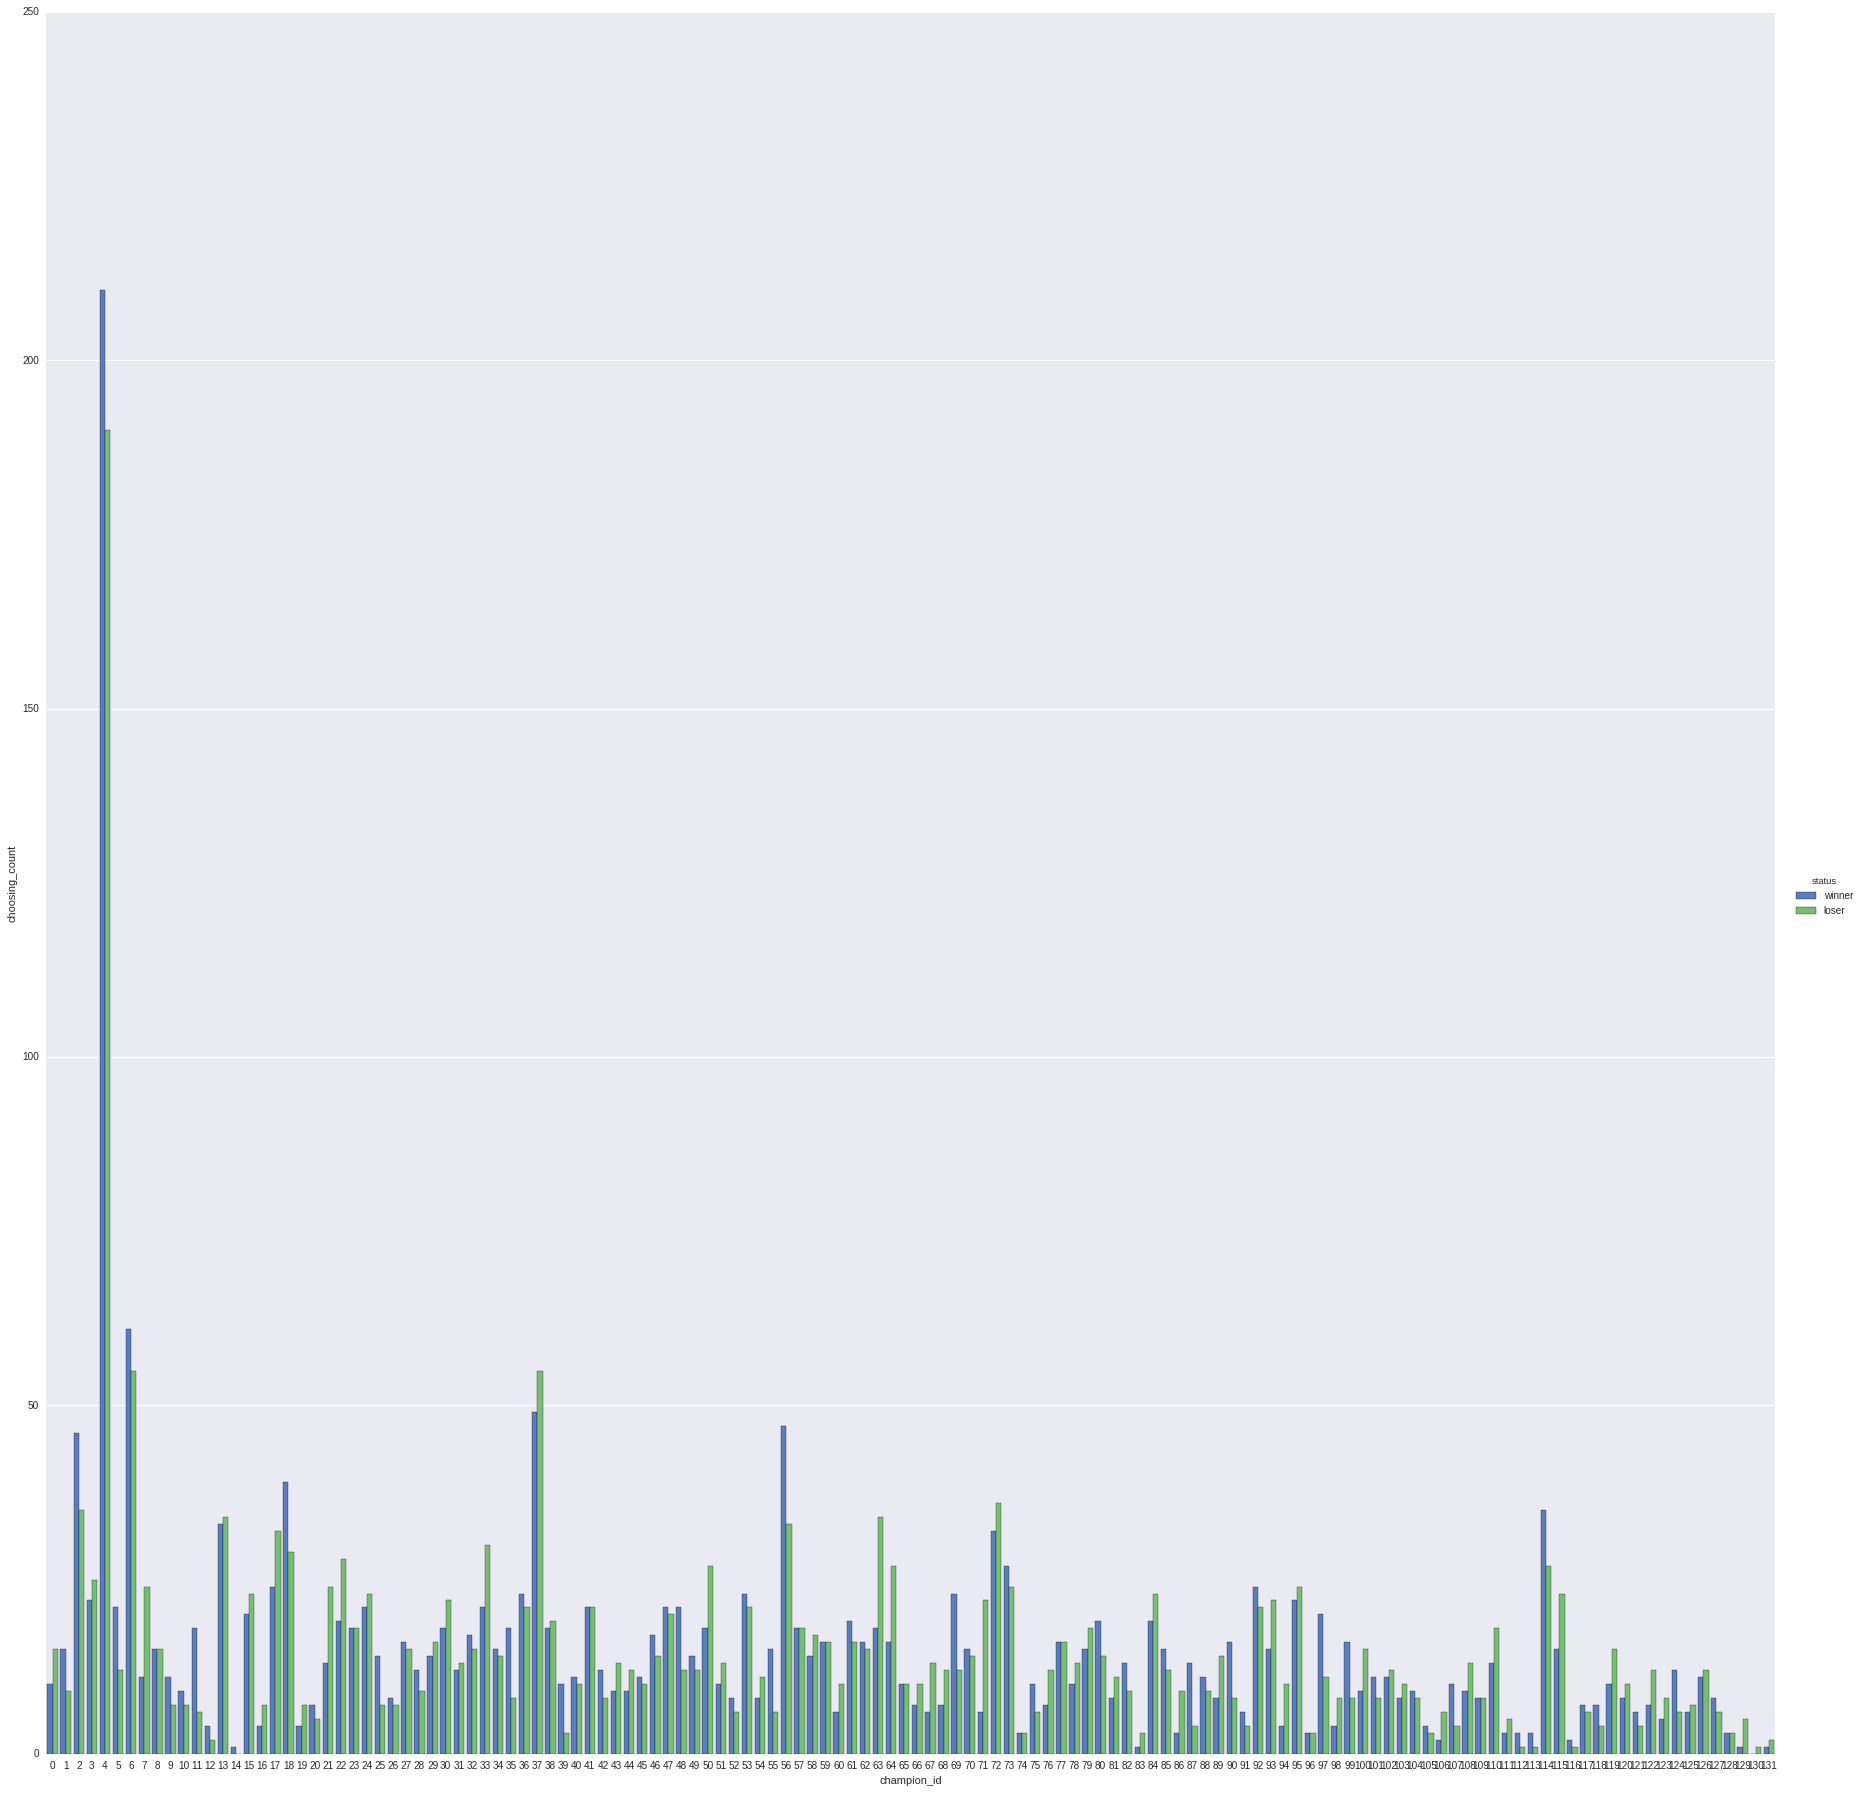

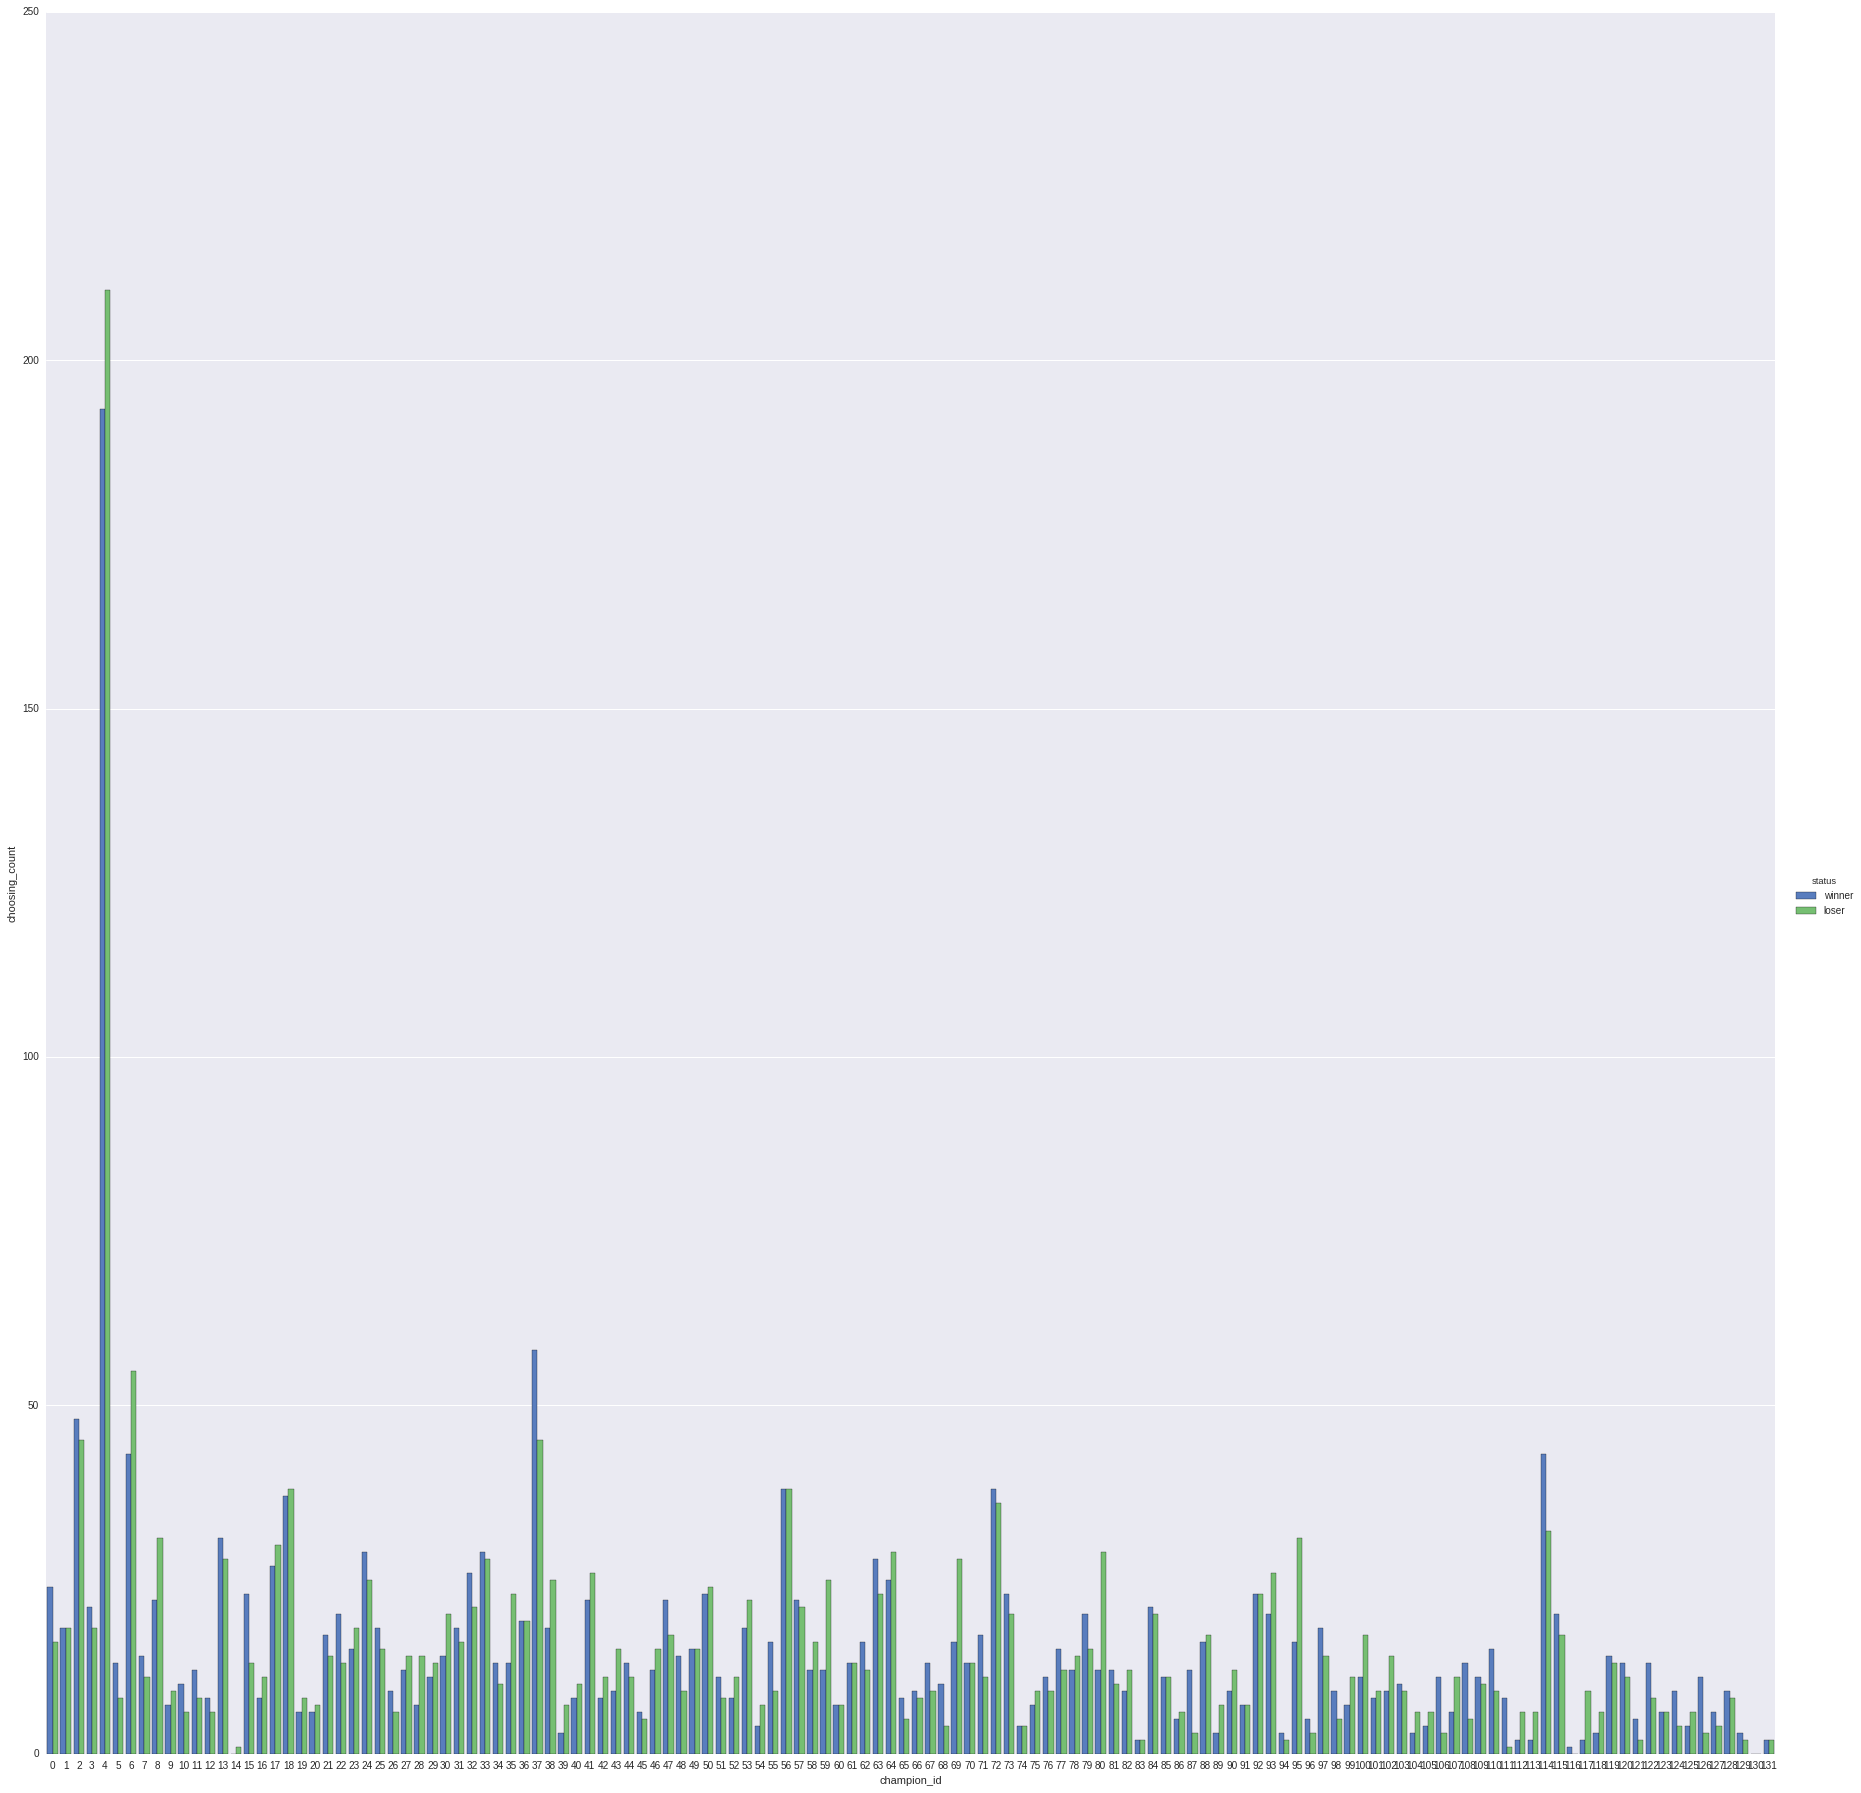

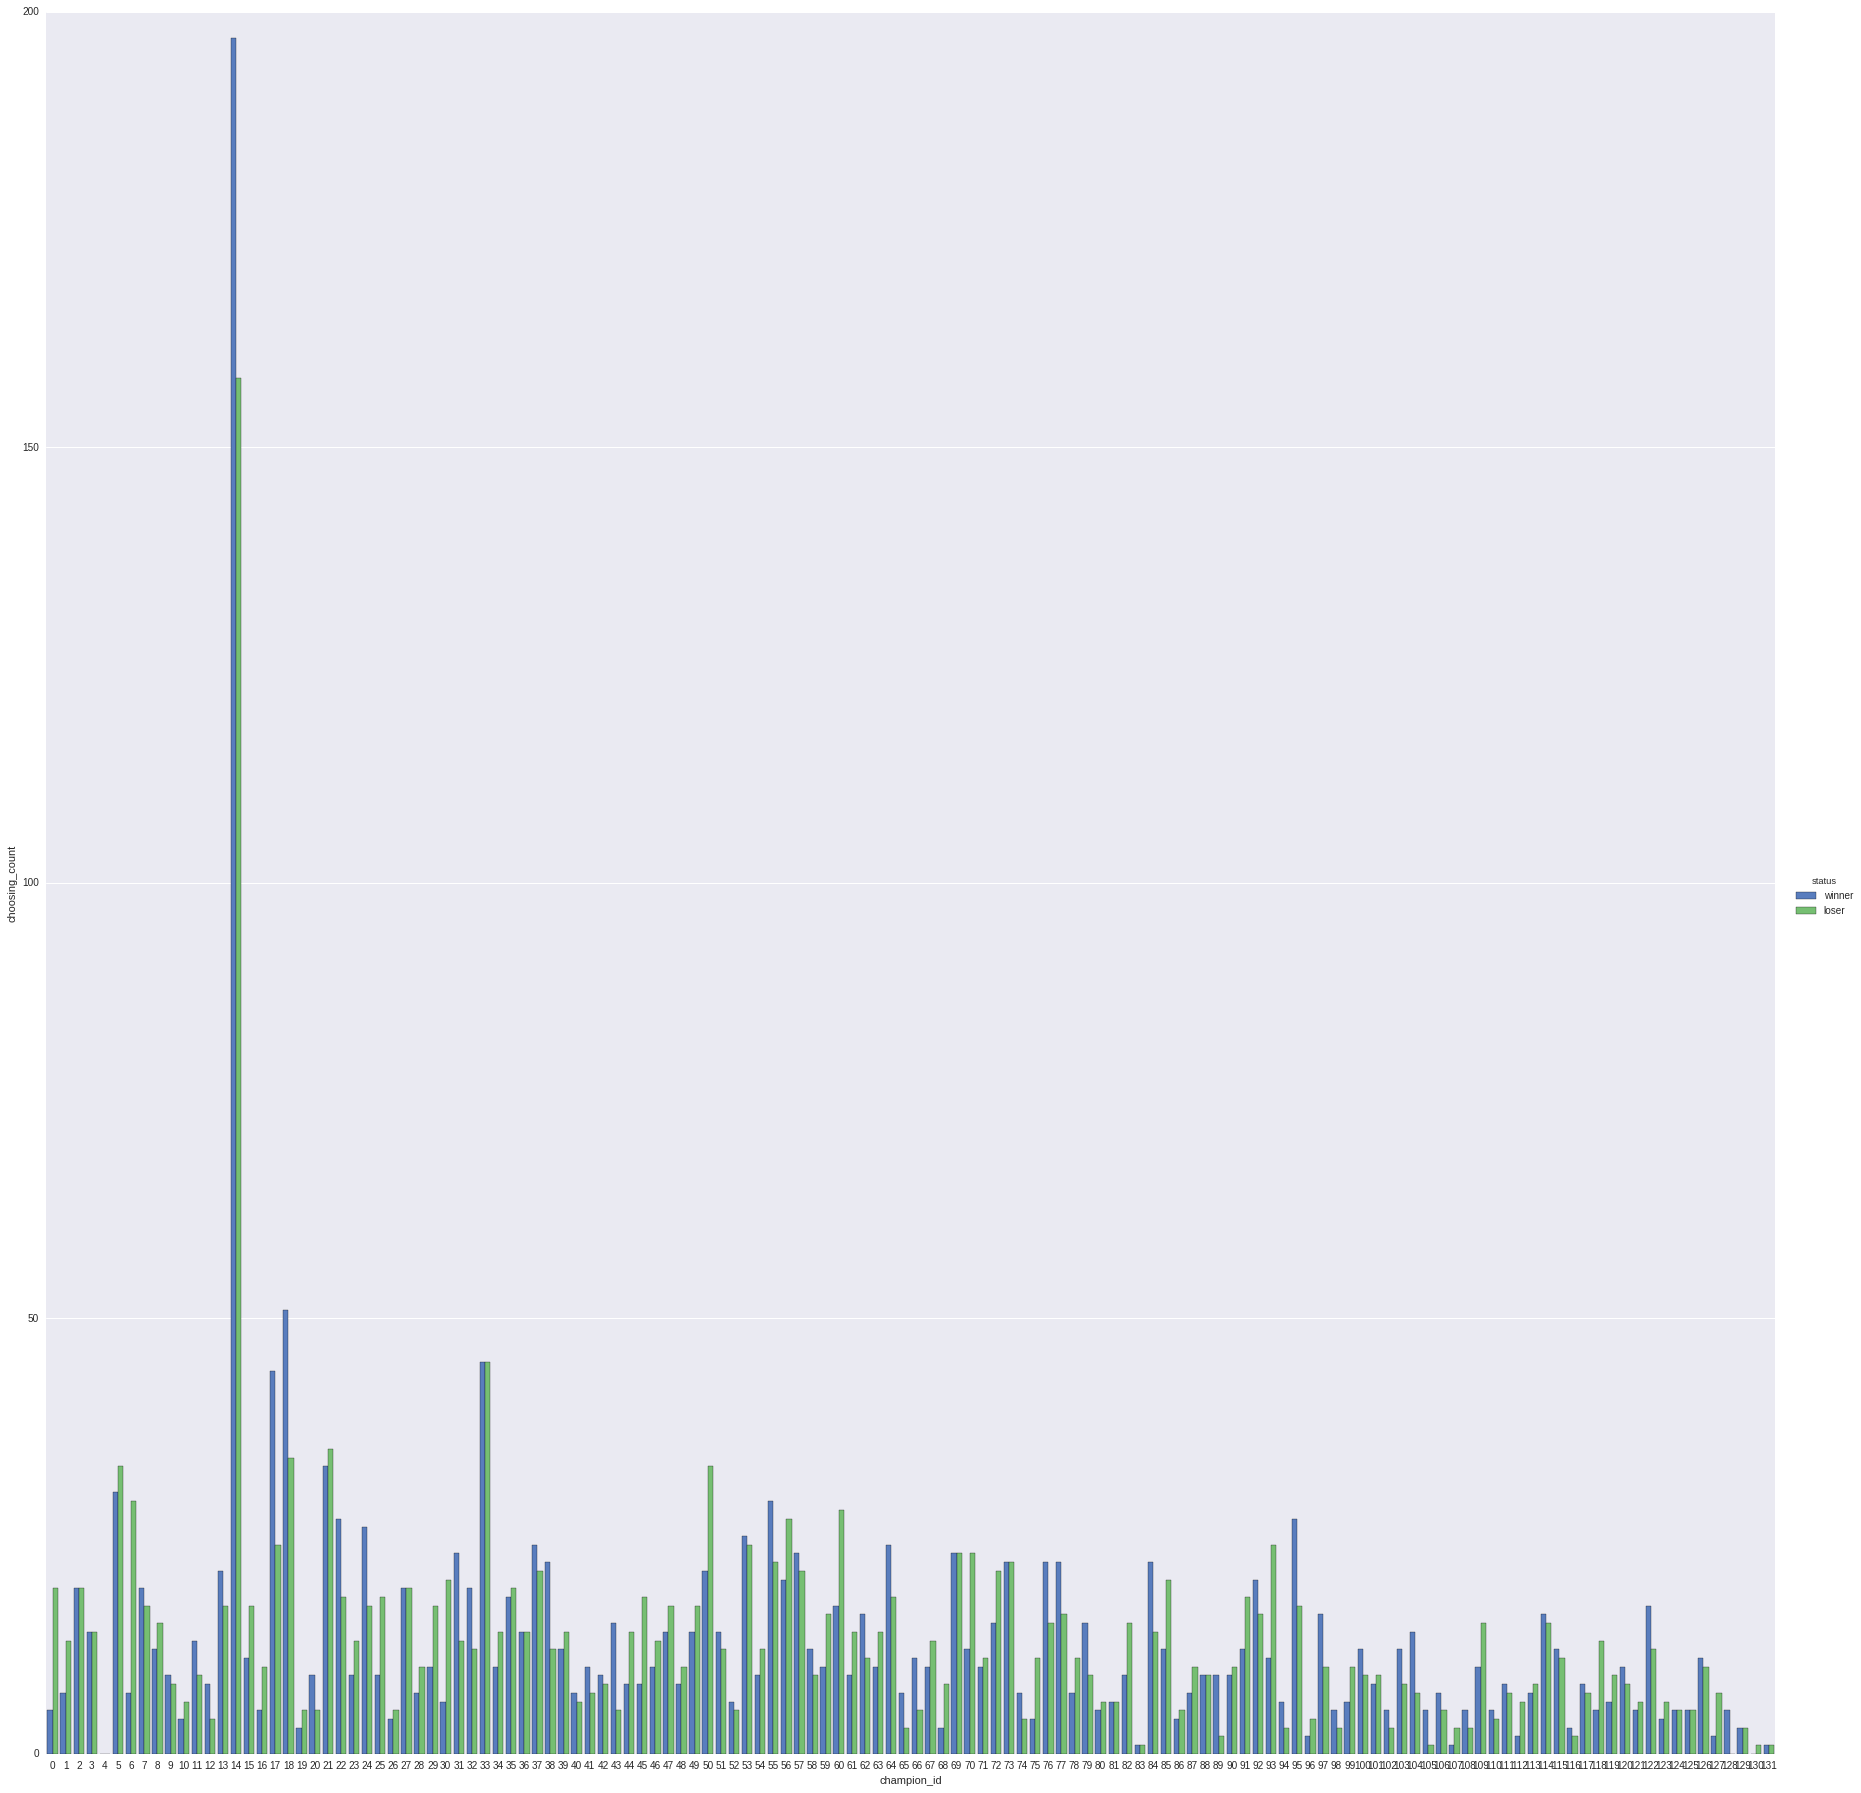

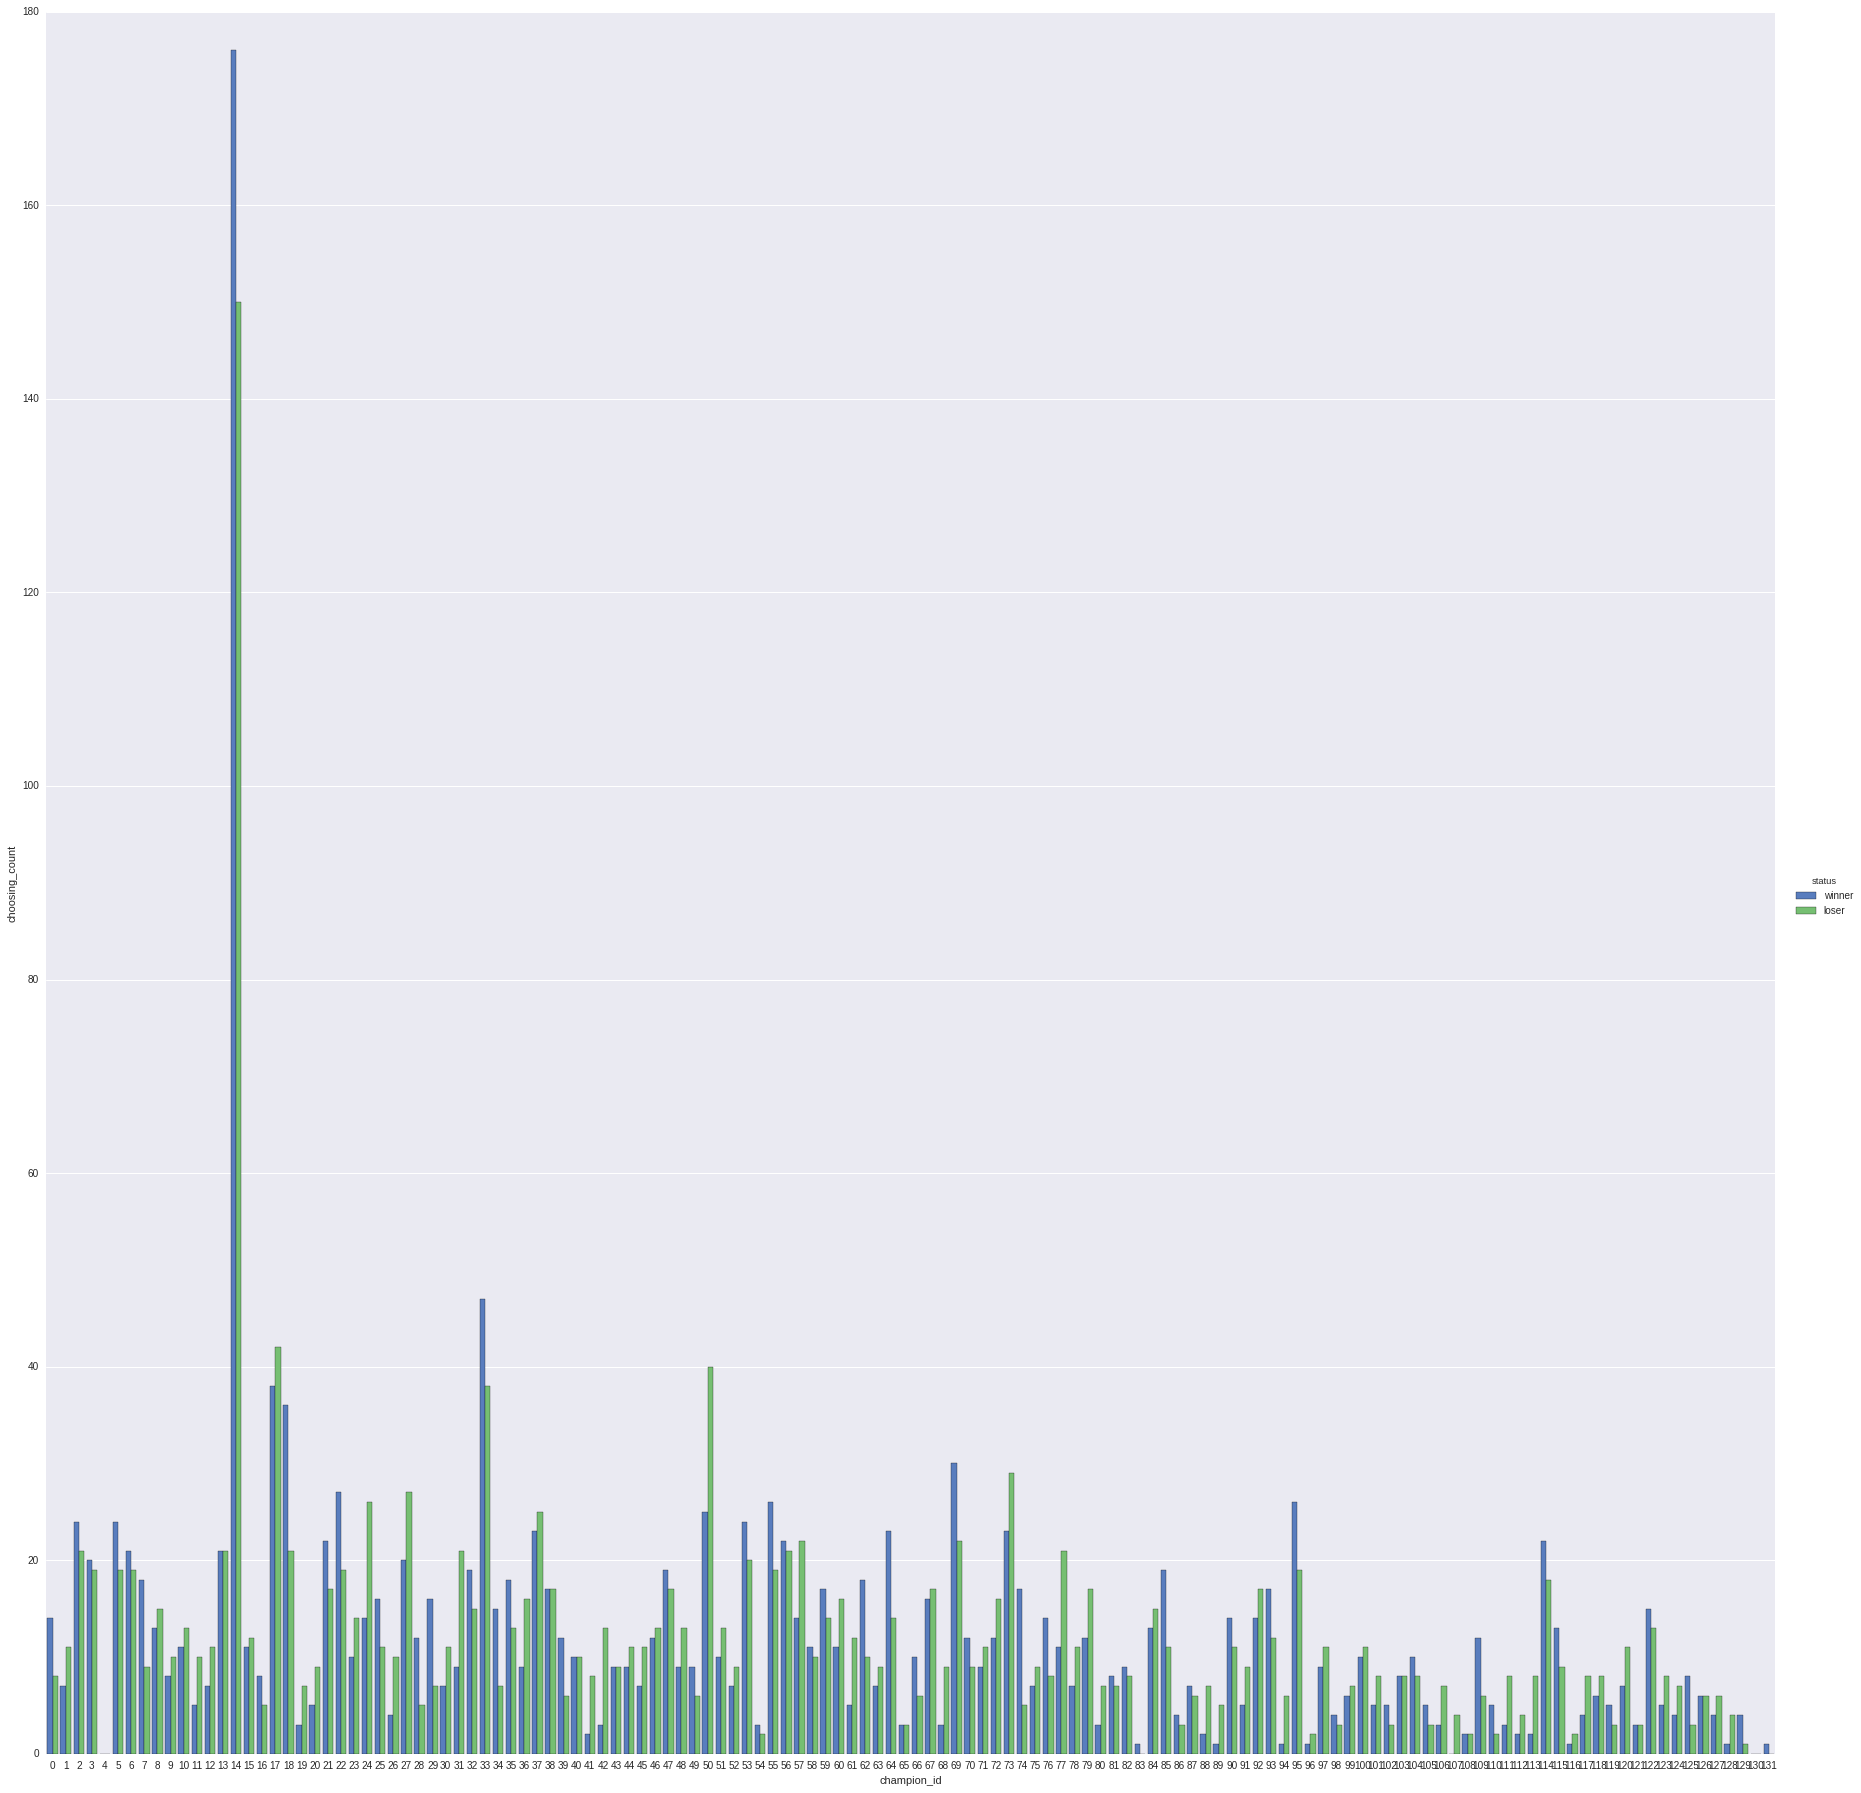

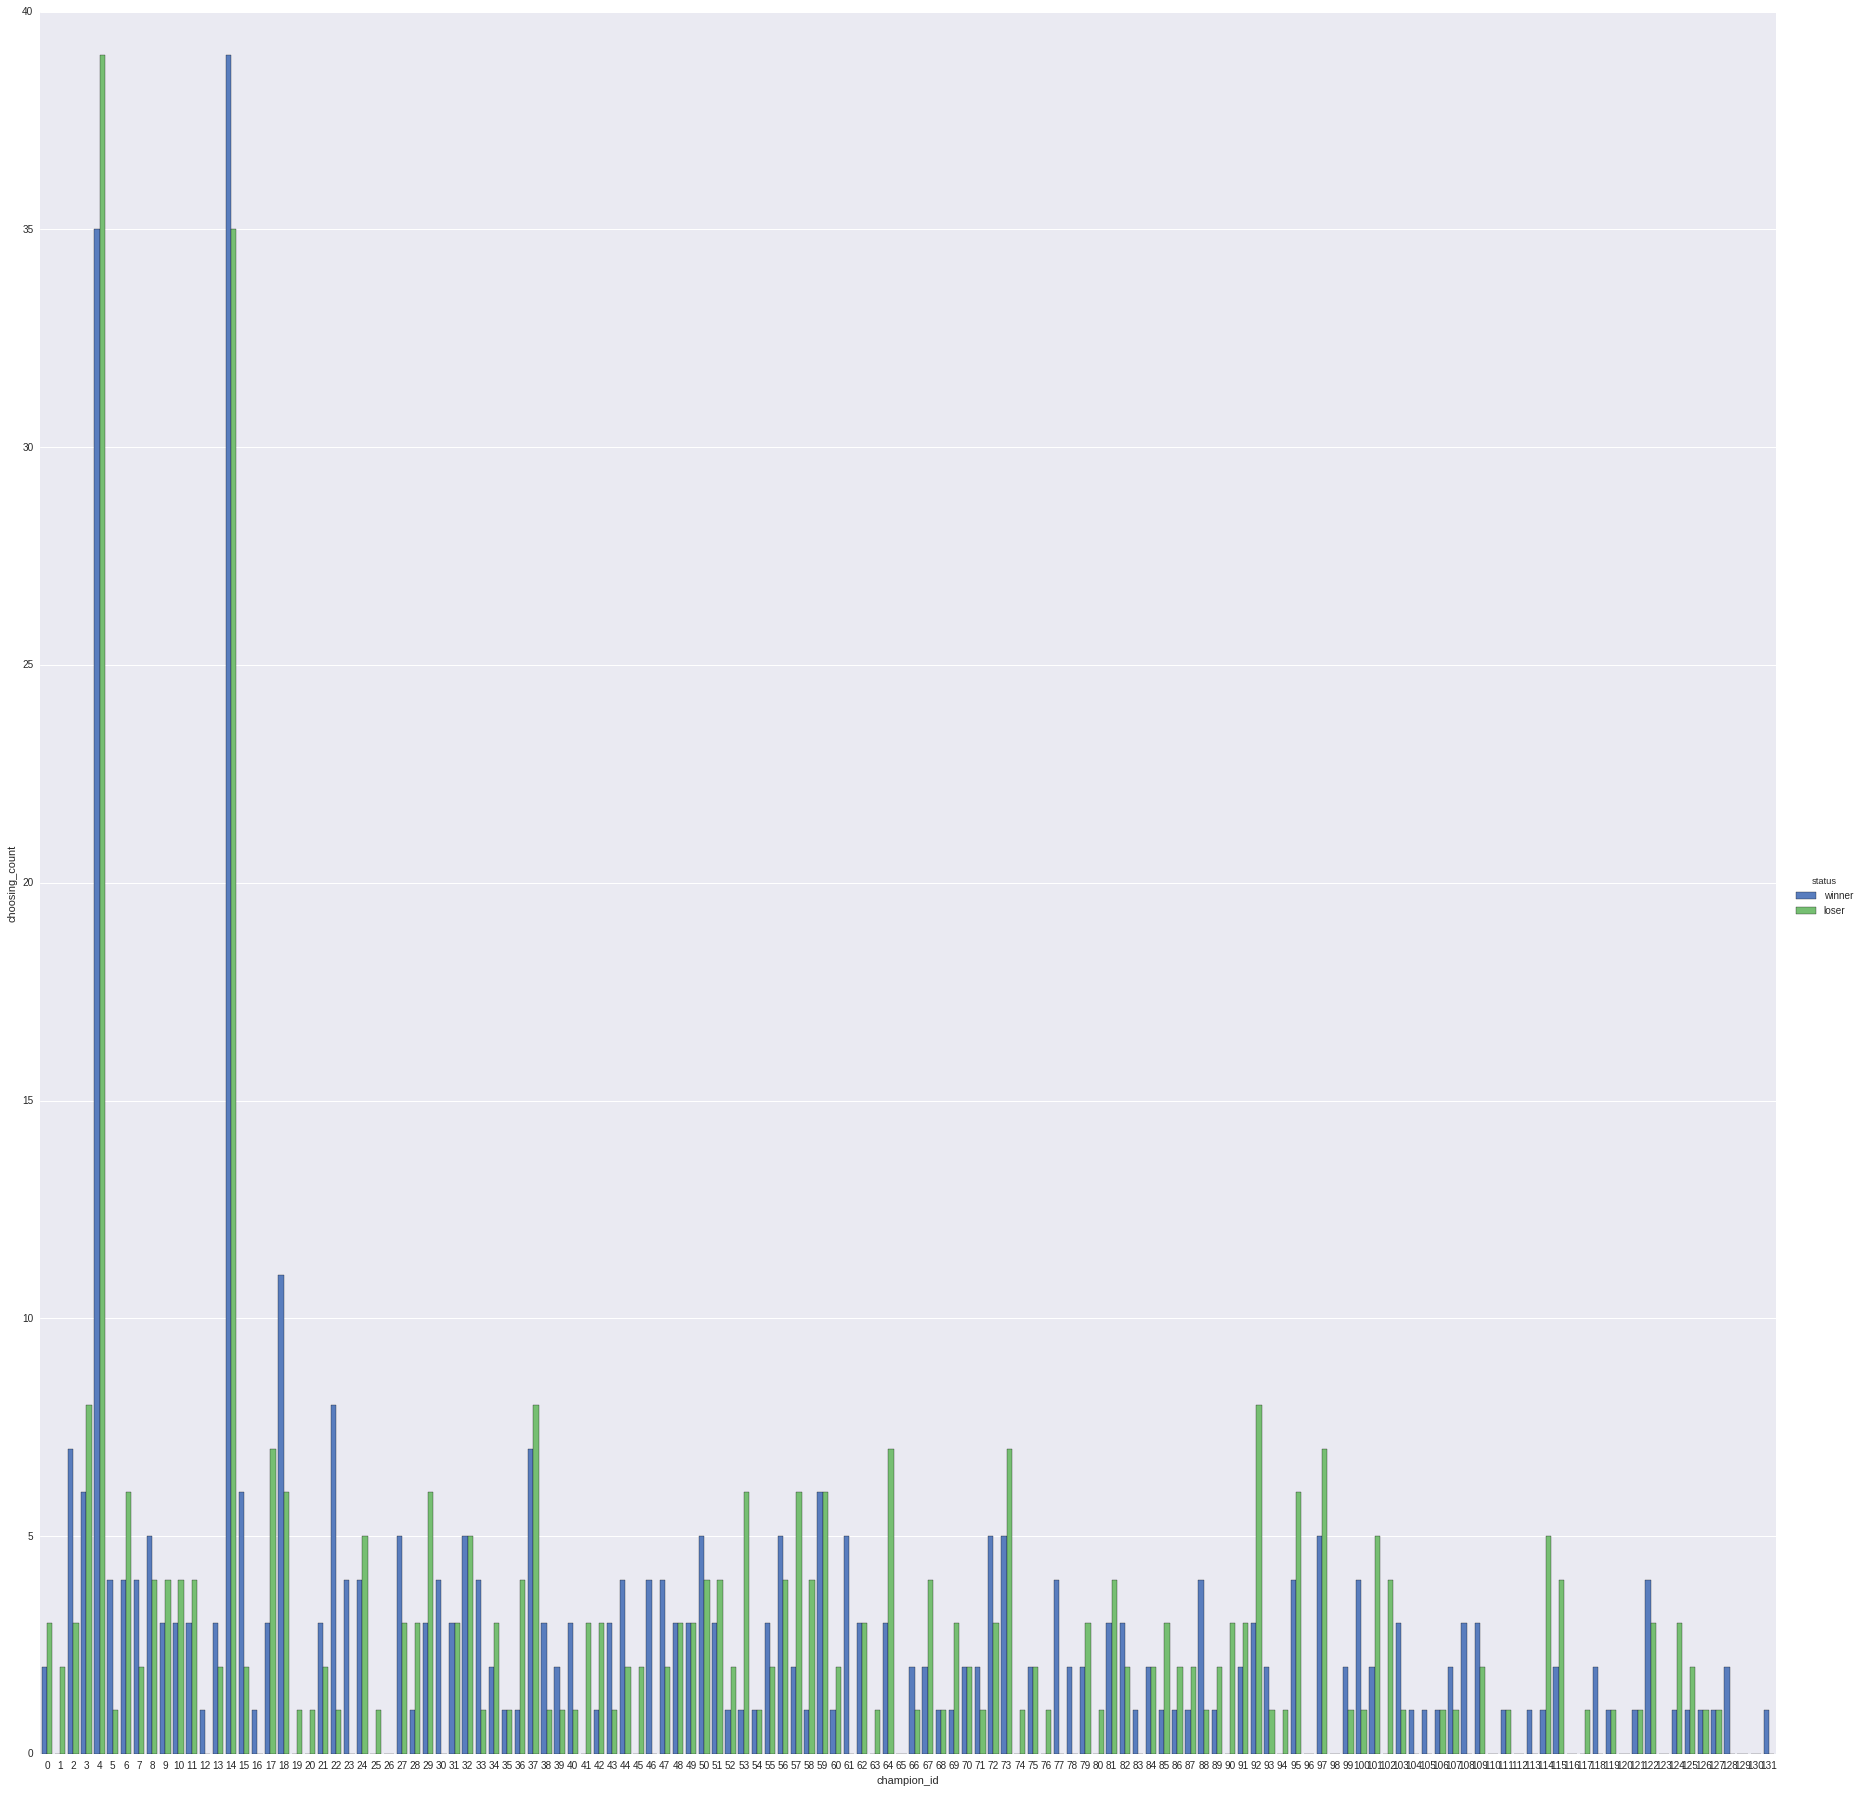

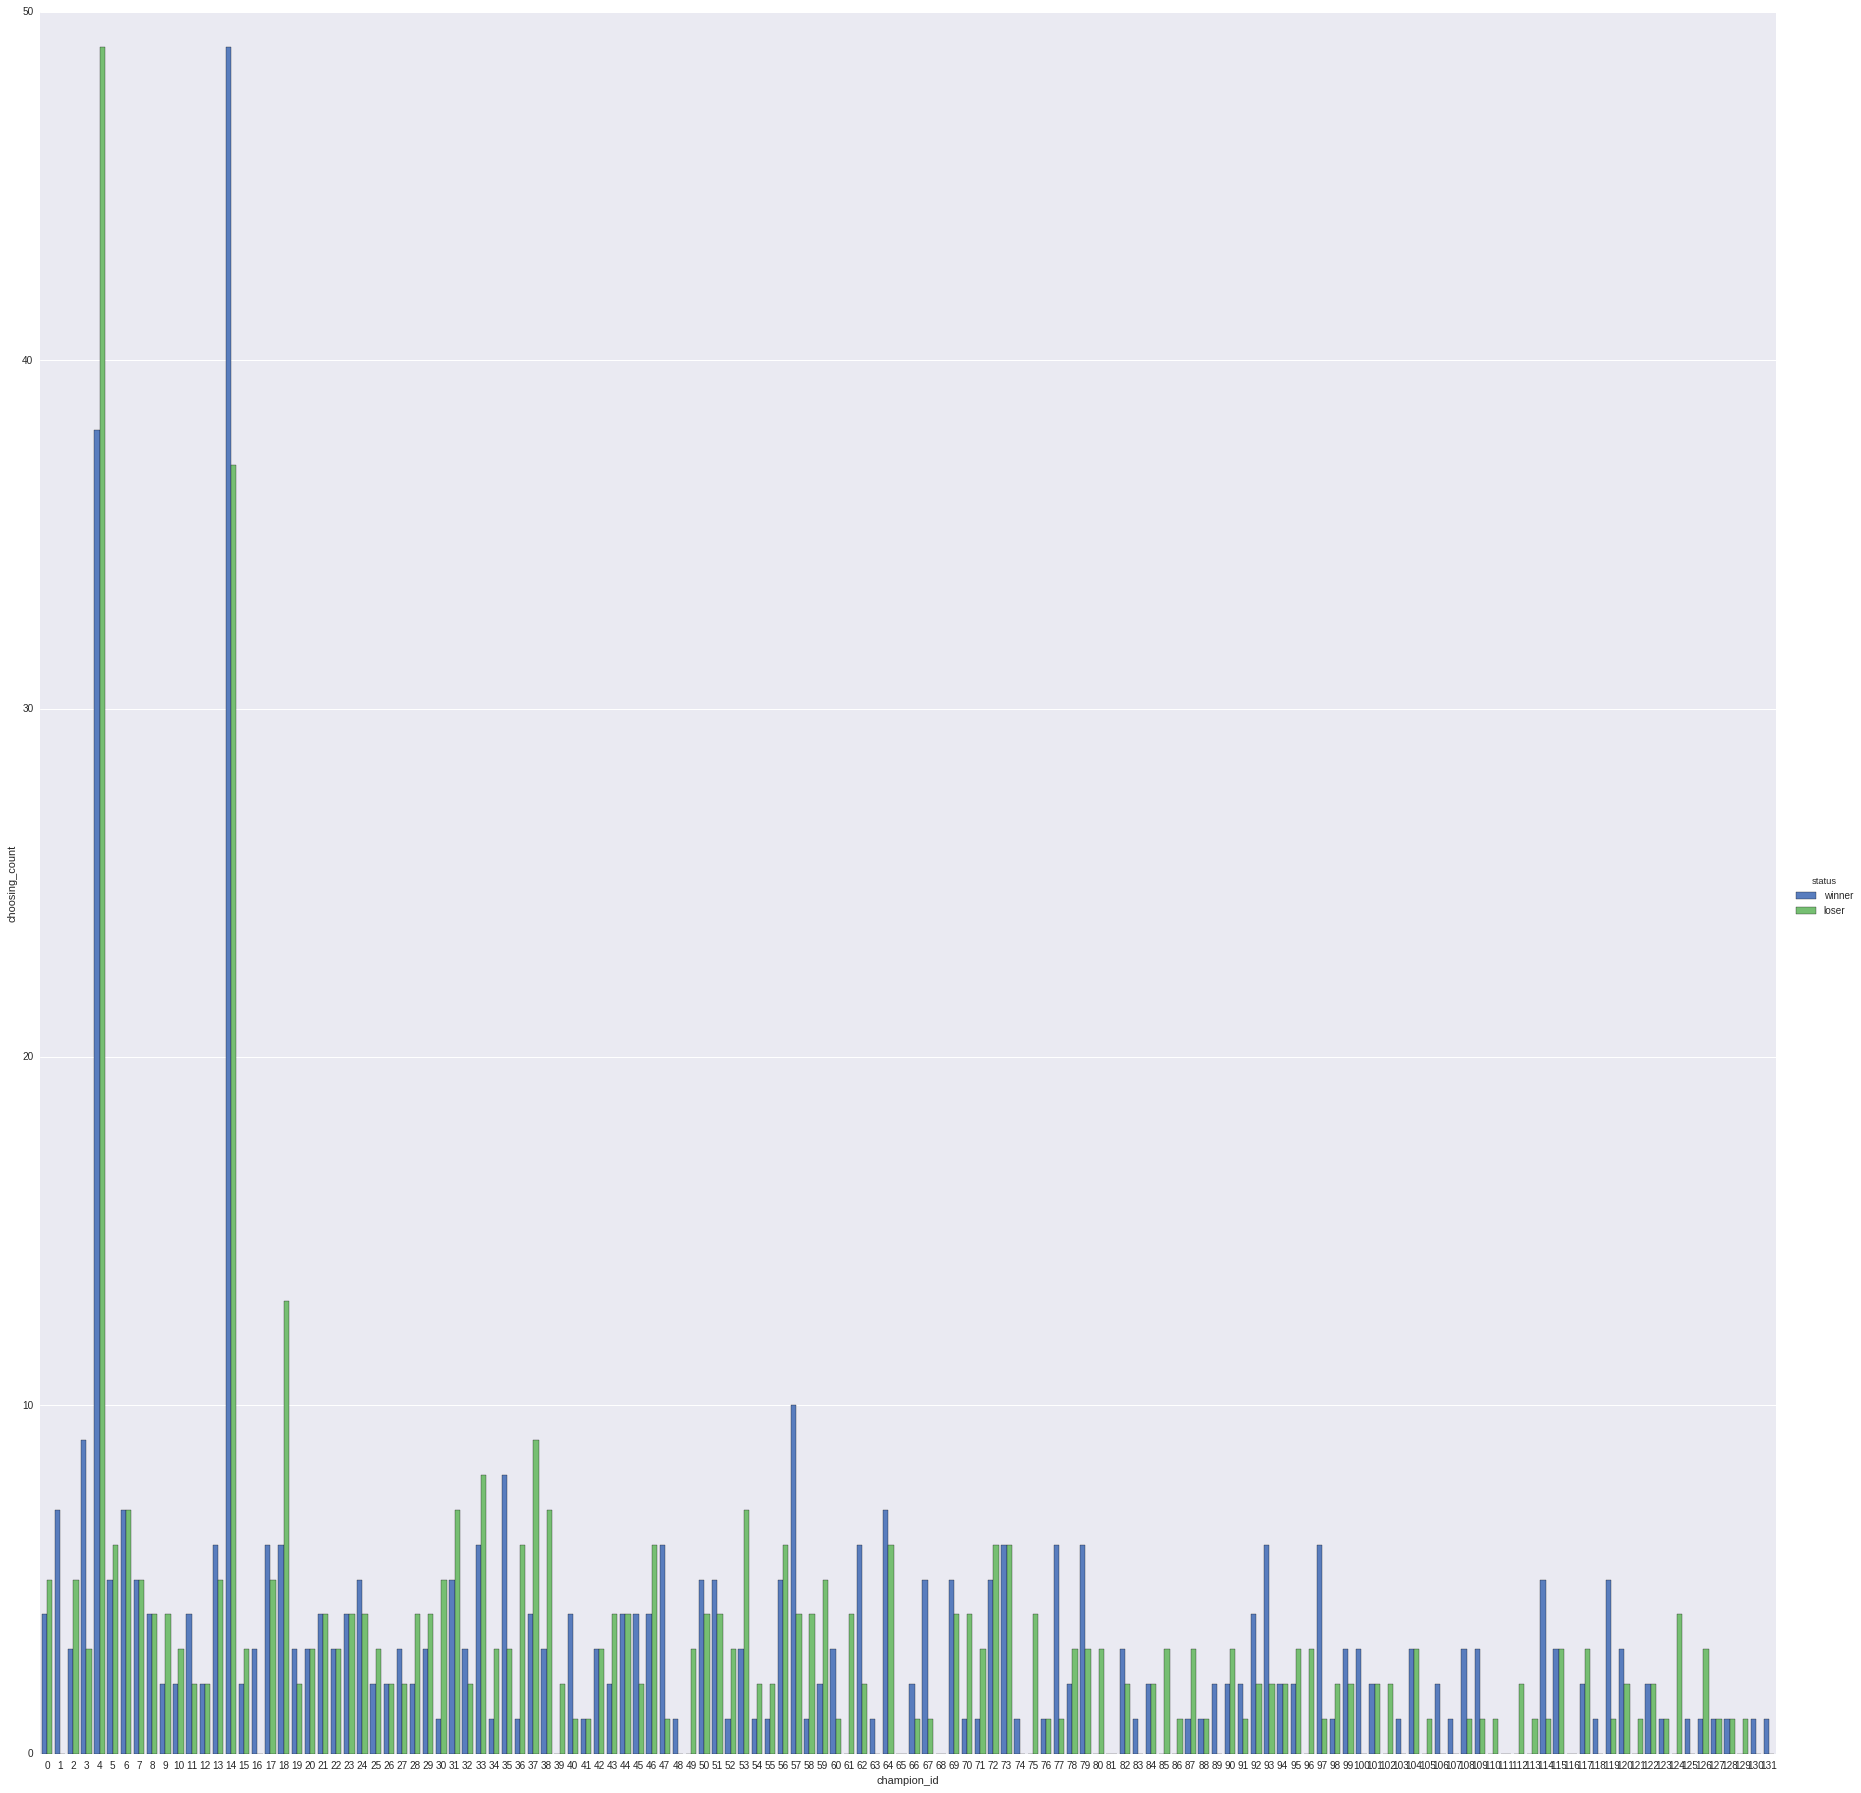

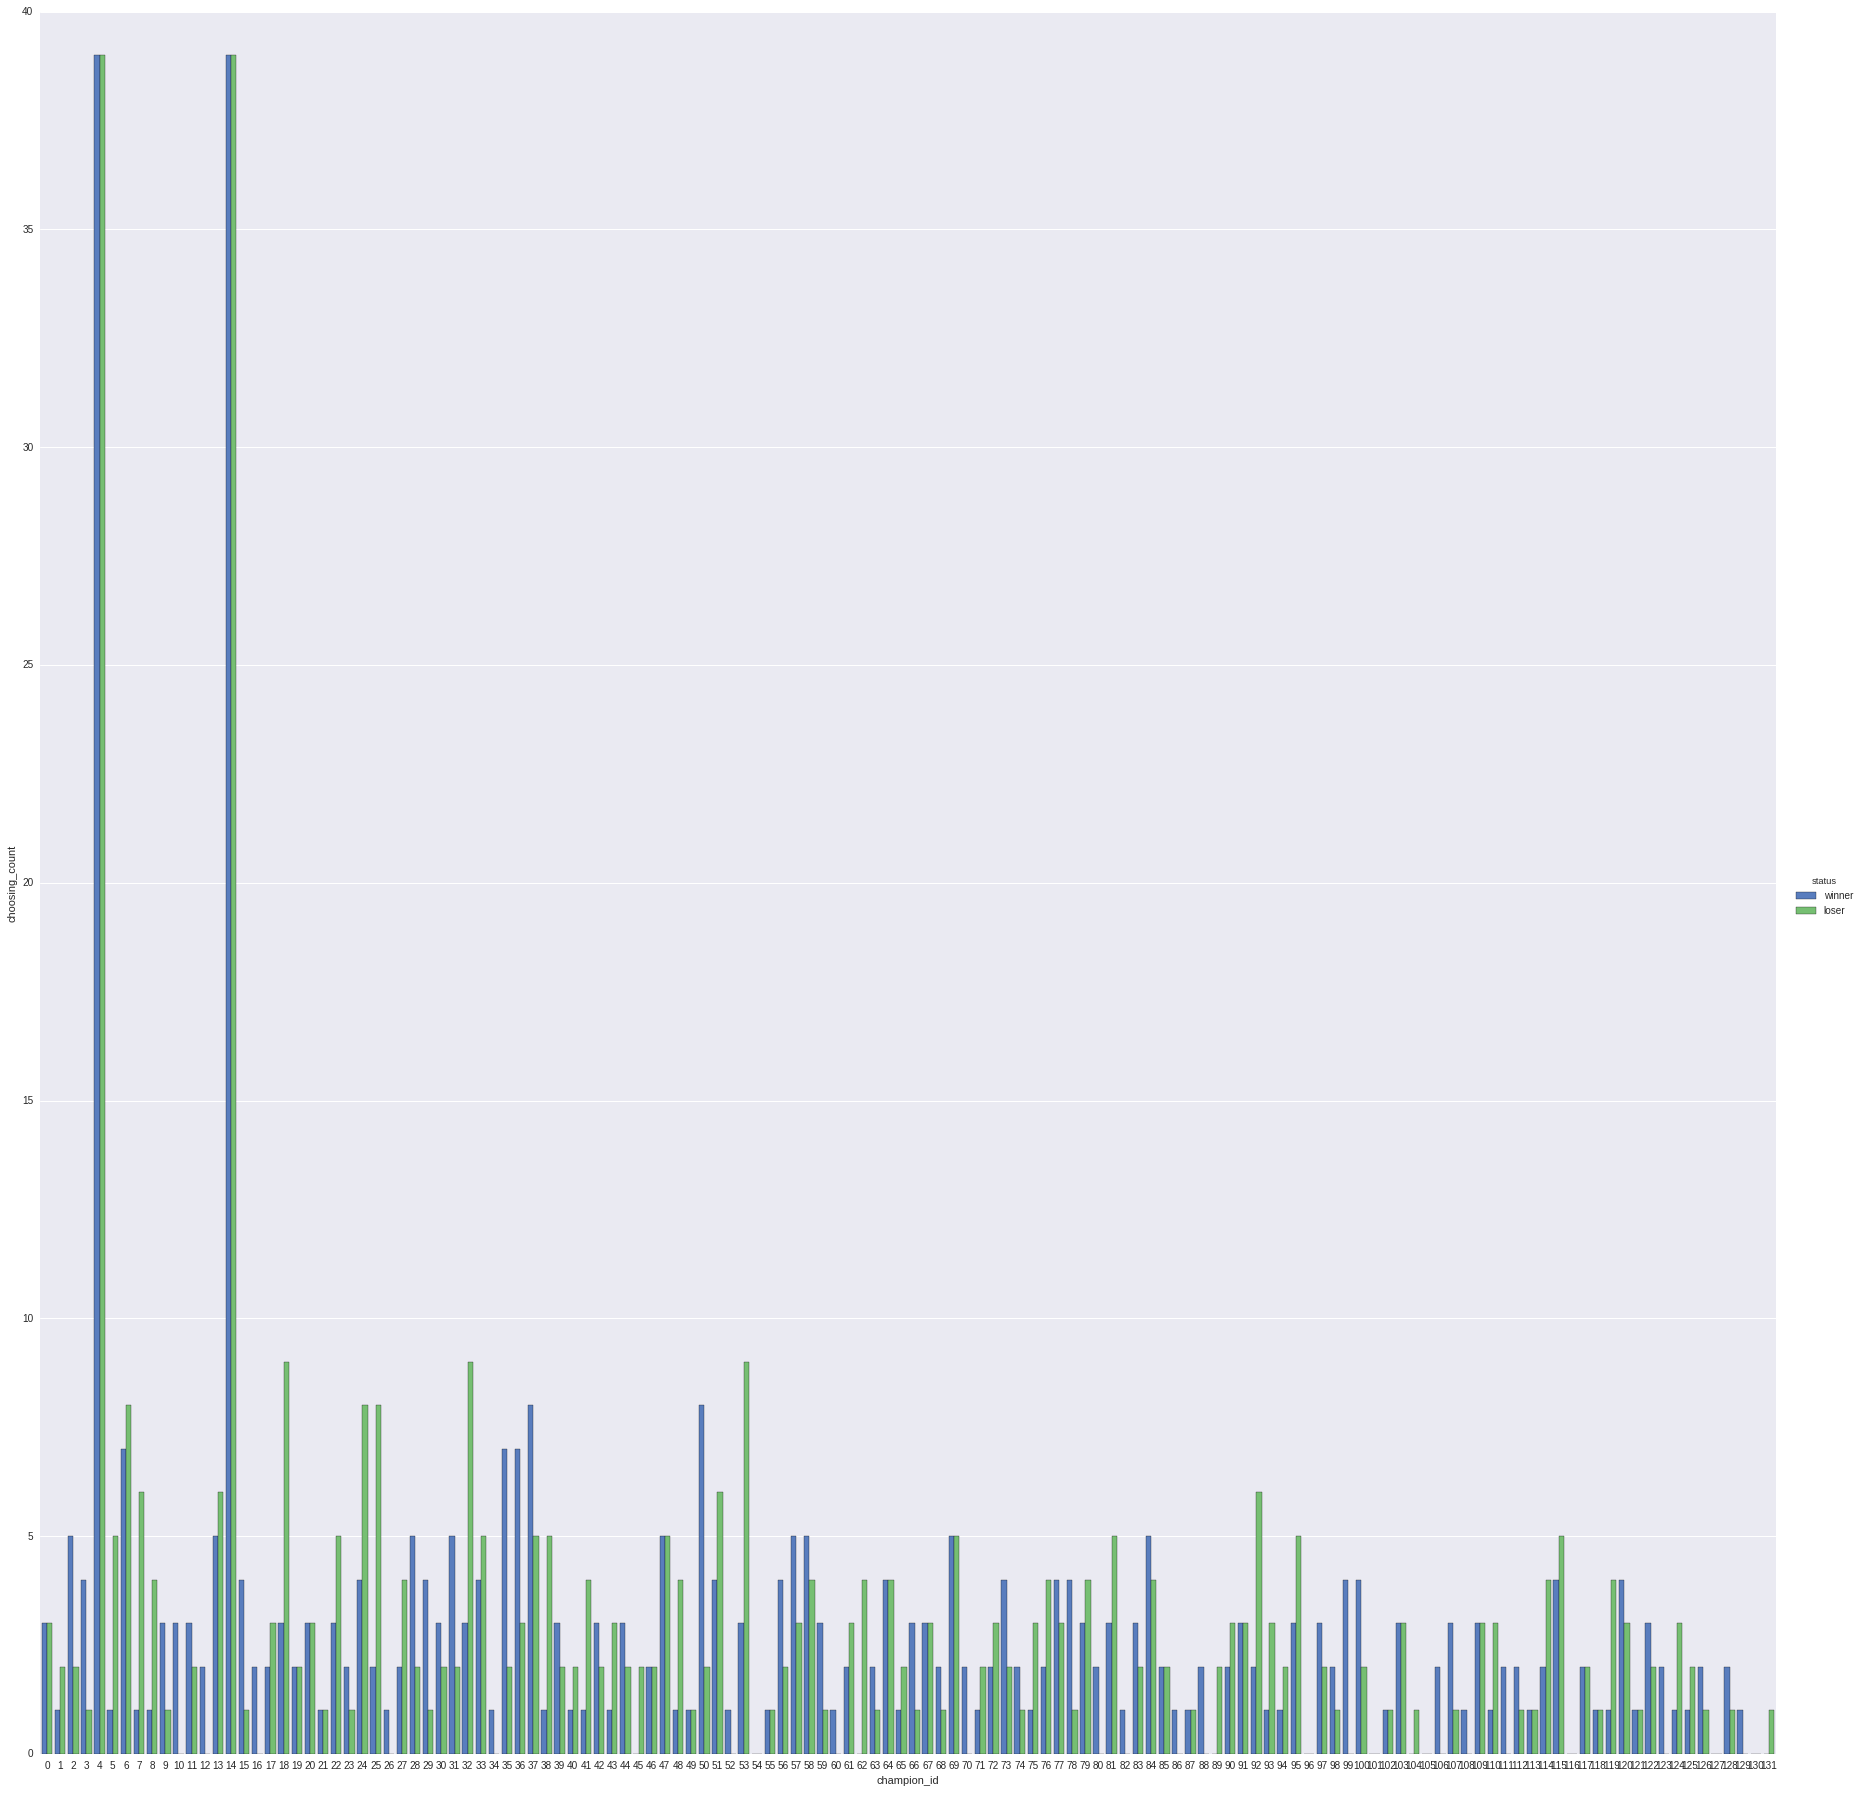

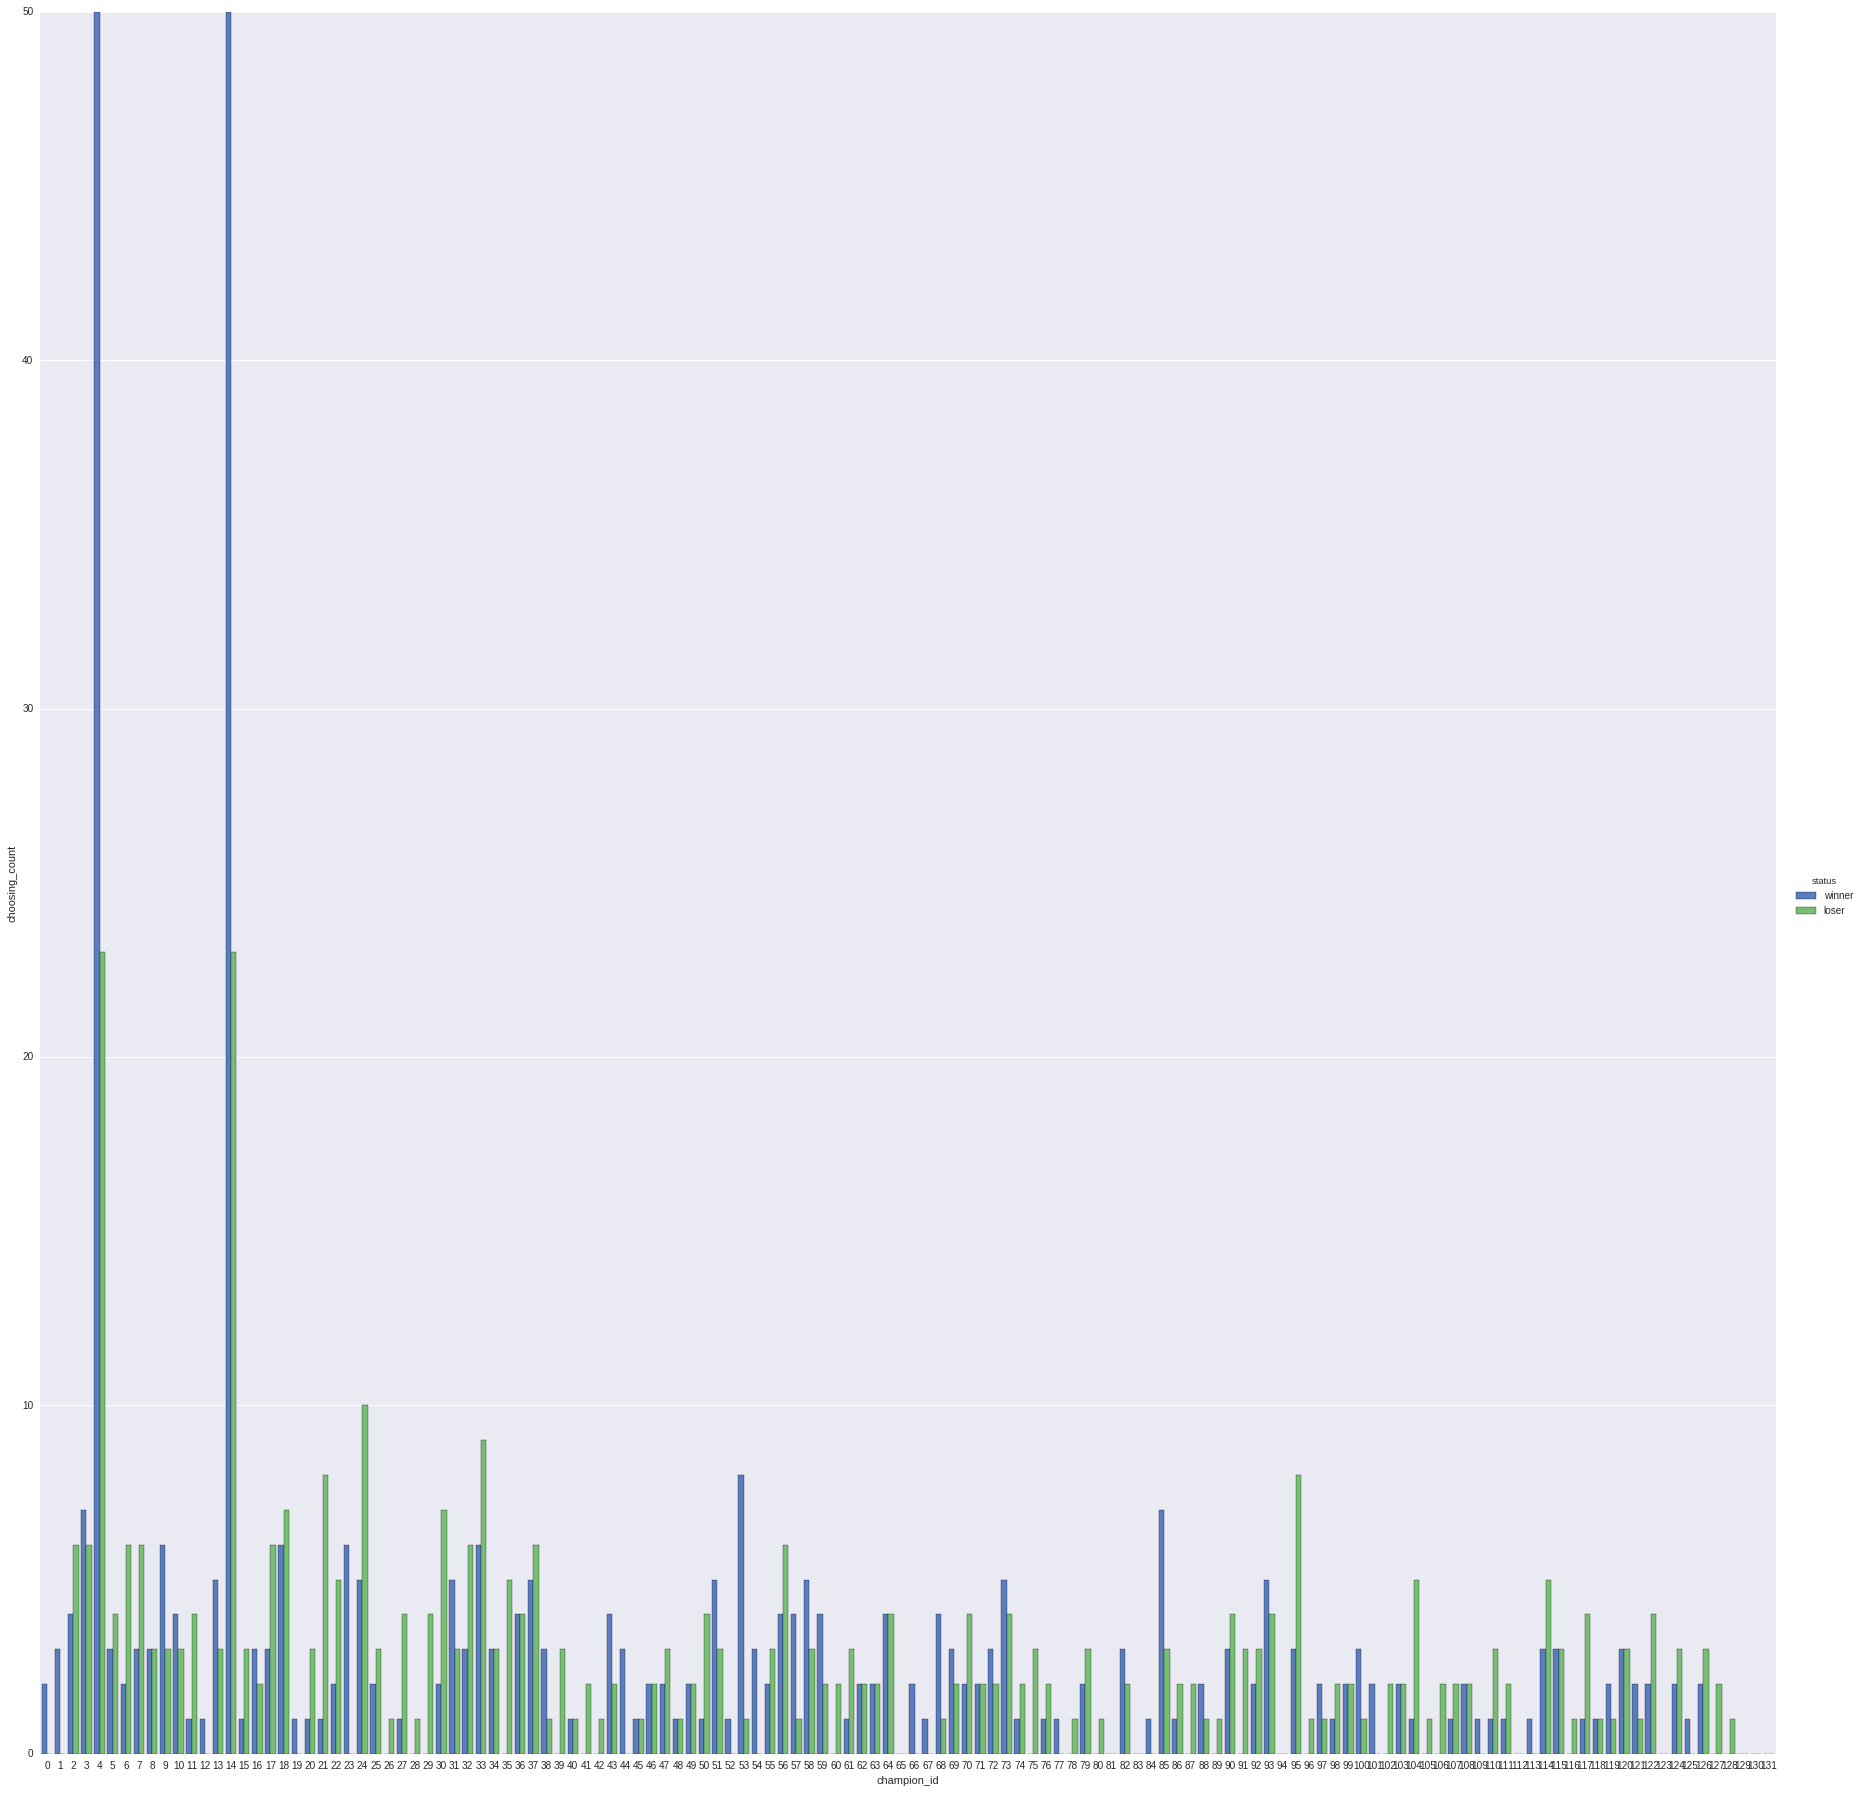

In [191]:
for i in range(9):
    print_one_cluster_champions(clustering, i)

Length of this cluster is: 73


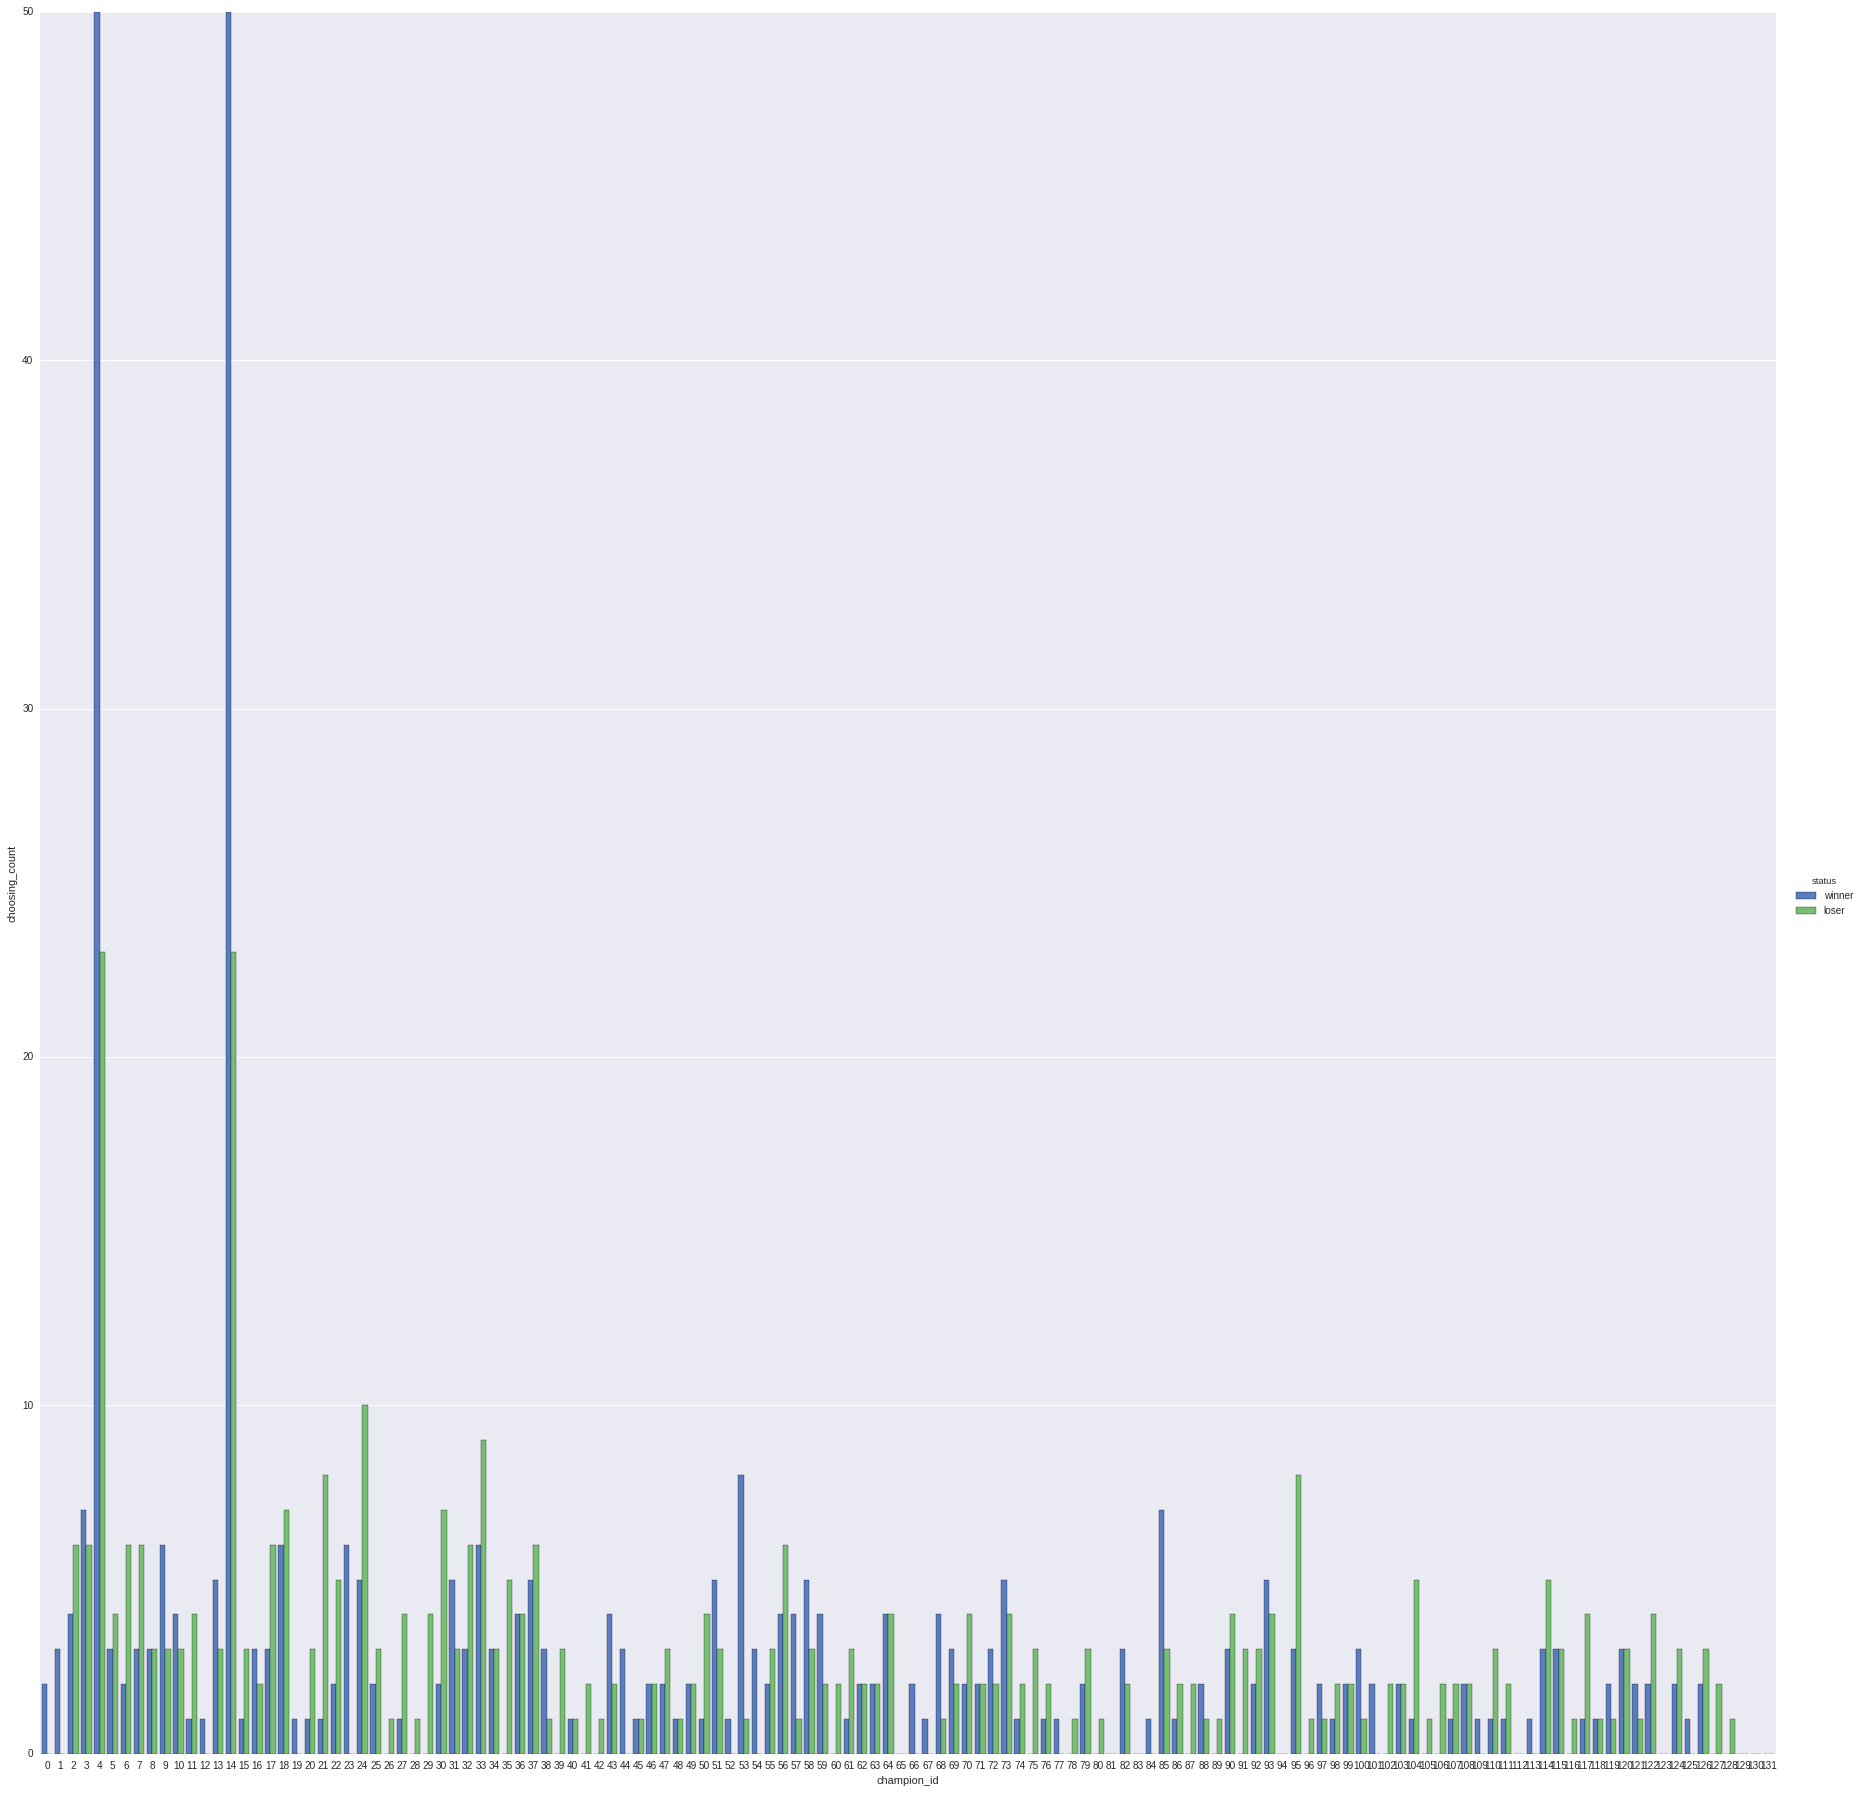

In [196]:
#good cluster to classify
print_one_cluster_champions(clustering, 8)

In [ ]:
%load plot_dendrogram.py

In [34]:
from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(ddd)

In [35]:
kde.score(ddd)

7854.3364452366286

In [47]:
kde.score(X[np.where(clustering.labels_==0)[0],:])

-3965.9122091551844

In [61]:
kde.score_samples(kde.sample())

array([ 50.07289703])